# Capture and Processing of Non-Destructive Data Streams
The output results of new non-destructive testing equipment needs to be analyzed over time to determine if process or equipment shifts occur. Process shifts will be detrimental to the company's ability to certify product, and may require additional rework. The project's focus will be on the development of the data-pipeline over the determination of process shifts. There are two major types of items that the inspection equipment will be reviewing. The first is production material. Detected flaws must be reacted to both upstream (fixing the cause) and downstream (responding to non-conforming product). The second type of item is a verification piece. The verification piece has known defects in the material of which all need to be found, at approximately the same detection level every time the verification is run. 

The inspection equipment has controlling GUI. The GUI allows fro the review inspection results, but it is not an acceptable method to perform automatic reviews of the data. The GUI executable does expose a socket based API which allows for machine to machine data transfer. Some test result values are compiled by GUI, and can be retrieved. These results are not representative of all needed parameters which are important to the business operation e.g. (validating the inspection system is healthy). The raw stream data of the tests must also be extracted and processed for statistical characteristics. These characteristics will be tracked over time to look for process shifts. 

The raw data streams and interface have similarities to big data. The communications, analysis, data storage and tracking all need to be developed. These steps will include drawing from multiple data sources (TCP socket API, SQL), and publication of transformed data an SQL database in real time. Basic visualizations for determining process shifts should be included. 

# Required Data To Be Processed
A year ago, the NDT team determined what information will be necessary to capture on the verification rails either as a customer requirement or for process understanding. For the scope of this project, I will be focused on the calibration/verification data rather than product data. Below is a listing of those requested data.

In [18]:
import pandas as pd
pd.read_csv('target_data_capture.csv')

,Equipment,KPI's to be measured/recorded,Olympus L2 Commands/Events,Data Source
0,Calibration,Calibration inspection number,Set Name (check cal and inspection),JSON/SQL
1,Calibration,Target identifier,Get Calibration Defect,JSON
2,Calibration,target location,Get Calibration Defect,JSON
3,Calibration,Found/Not found,Get Check Calibration Results or Verdict,JSON
4,Calibration,Primary probe used,Get Curve,JSON
5,Calibration,Signal amplitude,Get Check Calibration Results,JSON
6,Calibration,Expected response?,Get Check Calibration Results,JSON
7,Calibration,signal noise level,Get Curve,Stream
8,Calibration,Signal to Noise ratio,Get Curve,Stream
9,Calibration,Calibration rail number,Set Calibration Defect,JSON/SQL


# Import Known Defect Data

In [140]:
target_locations_raw = pd.read_excel('TargetLocations.xlsx')[[
    'inspection_equipment', 
    'channel', 
    #'section', 
    'axial_location',
    #'axial_location_reverse',
    'offset_distance', 
    #'axial_location_mm',
    'axial_location_reverse_mm', 
    'offset_distance_mm', 
    #'description',
    #'Target Reference', 
    #'Target Description', 
    #'Area on Rail', 
    #'Stamp/Brand',
    #'Target Size (inches)', 
    #'Target Type'
    ]]
target_locations_raw

,inspection_equipment,channel,axial_location,offset_distance,axial_location_reverse_mm,offset_distance_mm
0,UT,NaN,15.0,0.789,6319.012,20.0406
1,UT,NaN,16.0,1.289,6293.612,32.7406
2,UT,NaN,17.0,0.000,6268.212,0.0000
3,EC,IFS1:LT,21.0,1.750,6166.612,44.4500
4,EC,IFB1:LT,21.0,1.750,6166.612,44.4500
...,...,...,...,...,...,...
127,UT,H1-2,36.0,0.000,5785.612,0.0000
128,UT,H1-2,39.0,0.430,5709.412,10.9220
129,UT,H1-1,42.0,0.430,5633.212,10.9220
130,UT,H1-1,45.0,0.000,5557.012,0.0000


Simple seperator, Develop a range for each target. Hard cut off, half way between each 

statement about finding length measurement reversed later

In [141]:
def generate_target_boundaries(df):
    col = 'axial_location_reverse_mm'
    boundary_limit = 100
    df = df.sort_values(col)
    shifted = pd.concat(
        [
            df[col],
            df[col].shift(periods=1, fill_value=0),
            df[col].shift(periods=-1, fill_value=6500)
        ],
        axis=1, 
        keys=['orig', 'pre', 'post']
    )

    df['pre'] = shifted.apply(
        lambda x: x.orig - boundary_limit \
            if (x.orig - x.pre) > boundary_limit \
            else (x.orig + x.pre)/2,
        axis=1
    )
    df['post'] = shifted.apply(
        lambda x: x.orig + boundary_limit \
            if (x.post -x.orig) > boundary_limit \
            else (x.orig + x.post)/2,
        axis=1
    )

    return df

target_locations = (
    target_locations_raw
    .groupby('channel')
    .apply(generate_target_boundaries)
    .drop(columns='channel')
)
target_locations

inspection_equipment  axial_location  offset_distance  \
channel                                                            
:OB     99                   EC           226.5            0.000   
        91                   EC           213.0              NaN   
B1:BR-1 35                   UT            87.0              NaN   
        30                   UT            79.0            0.625   
        27                   UT            76.0            0.000   
...                         ...             ...              ...   
W2:ST-1 40                   UT            93.0            3.250   
        41                   UT            93.0            4.030   
        36                   UT            90.0            2.470   
        37                   UT            90.0            3.250   
        38                   UT            90.0            4.030   

            axial_location_reverse_mm  offset_distance_mm       pre      post  
channel                                                                        
:OB     99                    946.912               0.000   846.912  1046.912  
        91                   1289.812               0.000  1189.812  1389.812  
B1:BR-1 35                   4490.212               0.000  4390.212  4590.212  
        30                   4693.412              15.875  4593.412  4731.512  
        27                   4769.612               0.000  4731.512  4807.712  
...                               ...                 ...       ...       ...  
W2:ST-1 40                   4337.812              82.550  4337.812  4337.812  
        41                   4337.812             102.362  4337.812  4375.912  
        36                   4414.012              62.738  4375.912  4414.012  
        37                   4414.012              82.550  4414.012  4414.012  
        38                   4414.012             102.362  4414.012  4514.012  

[122 rows x 7 columns]

# Configuring Test Equipment Database
The test database for the test equipment was provided by the vendor as a backup of a MS SQL server database, which was used during a factory acceptance test. It contains scans from verification material; flaws should be consistent. 

The database was version of the database was 15 (Server 2019). The only offline databases I had write permissions to was an earlier version, so I was unable to upload the newer version to it due to version incompatibility. 

I explored an alternate method of creating a Windows 10 virtual machine on my desktop and installing the latest version of SQL server express on it. Although it did work, the needed networking configuration to communicate with the other source databases was complicated by IT network policies.

After some additional research, I discovered MS SQL local database. After installing the SQL kernel, I was able to create a local only database which is suitable for small application development. The SQL database connection is exposed via a local host network pipe protocol. Once connected using the network pipe, the SQL server acts as if it was a full SQL server. This is an interesting alternative to a SQLite database for small applications. One of the more annoying aspects of using this method is that every instance of the database, once closed, changes its pipe path. 

I wrote a function in Python to run the windows executable and capture the STDOUT and extract the pipe path so it could be passed as the host for a connection string.

In [47]:
def start_local_test_db(db_name='EvidentTestDB'):
    """
    Starts local database instance if it isn't running yet
    db_name: str target database name
    Returns:
    host: str host pipe path for connection
    """
    import subprocess
    import re
    sqllocaldb = r"C:\Program Files\Microsoft SQL Server\160\Tools\Binn\SqlLocalDB.exe" 
    response = subprocess.run(
        [sqllocaldb,'info', db_name], 
        stdout=subprocess.PIPE
    )
    
    if "Stopped" in response.stdout.decode('utf-8'): # Start DB
        subprocess.run([sqllocaldb,'start', db_name])
        response = subprocess.run(
            [sqllocaldb,'info', db_name], 
            stdout=subprocess.PIPE
        )
    elif 'doesn\'t exist' in response.stdout.decode('utf-8'):
        raise ValueError(f'Database {db_name} doesn\'t exist.')
    return re.search(r'\\\\.\\pipe\\LOCALDB#........\\tsql\\query', response.stdout.decode('utf-8'))[0]
ndt_host = start_local_test_db()
ndt_host

'\\\\.\\pipe\\LOCALDB#A4C967E8\\tsql\\query'

## Establish Connection to Local Database
Because of the sensitive nature of connection strings to company servers which include passwords, I import connection strings from an external file. This file is saved locally, and will not get uploaded to the repository. The connection string sqlalchemy compatible.

I have three methods to connect to the database; two methods will provide raw data in tabular format e.g. using python/pandas/sqlalchemy or jupyter notebook sql direct connection . The API both receives and sends data in JSON format. Stream data is sent over a separate port. 

When connecting in any method, the connection string needs to be established.

In [20]:
import pandas as pd
from sqlalchemy import create_engine, text
from connections import get_tracking_connection_str, get_ndt_connection_str

# jupyter notebook extension to run in line sql using ipython-sql
%load_ext sql

ndt_connection_str = get_ndt_connection_str(host=ndt_host)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Below is a demonstration of using `pandas` to connect to the database.

In [21]:
engine = create_engine(ndt_connection_str)
connection = engine.connect() #must close this at some point
output = pd.read_sql(text('SELECT * from Batch;'), connection)
connection.close()
output

,BatchIndex,OrderListNumber,Name,StartDate,EndDate,SteelType,Documents,Area,Thermal,FlowNumber,Customer,FK_B_OrderIndex,ProductDimension,ControlSpecification,OperatorName,Equipment,ProductPrefix
0,26,1,Test systeme,2022-03-28,2022-03-28,,,,,,,6,,,,,
1,27,2,Repetabilite,2022-03-28,2022-03-28,,,,,,,6,,,,,


Alternatively, this is the method to connect to the database using the in-line sql call.

In [22]:
# Tips on how to perform inline SQL found at
# https://www.sqlshack.com/learn-jupyter-notebooks-for-sql-server/

%sql $ndt_connection_str
%sql SELECT * from Batch;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


BatchIndex,OrderListNumber,Name,StartDate,EndDate,SteelType,Documents,Area,Thermal,FlowNumber,Customer,FK_B_OrderIndex,ProductDimension,ControlSpecification,OperatorName,Equipment,ProductPrefix
26,1,Test systeme,2022-03-28 00:00:00,2022-03-28 00:00:00,,,,,,,6,,,,,
27,2,Repetabilite,2022-03-28 00:00:00,2022-03-28 00:00:00,,,,,,,6,,,,,


# Exploring The Database Schema
Now that there is a functional connection established to the database, I can begin to explore the data contained within. First, I will look at the database schema to look for the most important tables and how they are connected together. Second, I will be looking at the API documentation to determine the best way to get the needed data out of the database. I expect the final solution will be a combination of the two data retrieval methods.

Using MSSQL's built in schema structure tables, I can see that there are 110 tables in this database. 

In [23]:
# Print table characteristics in database
%sql SELECT * FROM INFORMATION_SCHEMA.TABLES ORDER BY TABLE_NAME;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
EvrazL2Test,dbo,AlarmFilter,BASE TABLE
EvrazL2Test,dbo,AlarmFilterSetup,BASE TABLE
EvrazL2Test,dbo,AlarmInfoEC,BASE TABLE
EvrazL2Test,dbo,AppSetting,BASE TABLE
EvrazL2Test,dbo,Batch,BASE TABLE
EvrazL2Test,dbo,BatchCustomFieldTemplate,BASE TABLE
EvrazL2Test,dbo,BatchCustomFieldValue,BASE TABLE
EvrazL2Test,dbo,BatchEC,BASE TABLE
EvrazL2Test,dbo,BatchUT,BASE TABLE
EvrazL2Test,dbo,BenchInfo,BASE TABLE


I did some exploration of individual table schemas such as the structure of the `Batch` table, previously presented. I found that there was some structure regarding references to foreign keys. 

In [24]:
%sql SELECT top 10 * FROM Batch;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


BatchIndex,OrderListNumber,Name,StartDate,EndDate,SteelType,Documents,Area,Thermal,FlowNumber,Customer,FK_B_OrderIndex,ProductDimension,ControlSpecification,OperatorName,Equipment,ProductPrefix
26,1,Test systeme,2022-03-28 00:00:00,2022-03-28 00:00:00,,,,,,,6,,,,,
27,2,Repetabilite,2022-03-28 00:00:00,2022-03-28 00:00:00,,,,,,,6,,,,,


In [25]:
%%sql
SELECT schema_name(tab.schema_id) AS schema_name,
    tab.name as table_name, 
    col.column_id,
    col.name as column_name, 
    t.name as data_type,
    col.max_length,
    col.precision
FROM sys.tables as tab
    INNER JOIN sys.columns as col
        on tab.object_id = col.object_id
    LEFT JOIN sys.types as t
    on col.user_type_id = t.user_type_id
WHERE tab.name like 'Batch'
ORDER BY schema_name, table_name, column_id;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


schema_name,table_name,column_id,column_name,data_type,max_length,precision
dbo,Batch,1,BatchIndex,int,4,10
dbo,Batch,2,OrderListNumber,int,4,10
dbo,Batch,3,Name,nvarchar,200,0
dbo,Batch,4,StartDate,datetime,8,23
dbo,Batch,5,EndDate,datetime,8,23
dbo,Batch,6,SteelType,nvarchar,100,0
dbo,Batch,7,Documents,nvarchar,100,0
dbo,Batch,8,Area,nvarchar,100,0
dbo,Batch,9,Thermal,nvarchar,100,0
dbo,Batch,10,FlowNumber,nvarchar,100,0


The most useful part of this exercise is understanding the vendor's table and index name scheme. Their foreign keys are 'FK_\<abbreviation of current db\>_<connectedDB\>Index'. With this systematic approach in mind, I grabbed all of the columns in the database as a single DataFrame.

In [26]:
sql = '''--begin-sql
SELECT schema_name(tab.schema_id) AS schema_name,
    tab.name as table_name, 
    col.column_id,
    col.name as column_name, 
    t.name as data_type,
    col.max_length,
    col.precision
FROM sys.tables as tab
    INNER JOIN sys.columns as col
        on tab.object_id = col.object_id
    LEFT JOIN sys.types as t
    on col.user_type_id = t.user_type_id
ORDER BY schema_name, table_name, column_id;
--end-sql
'''
engine = create_engine(ndt_connection_str)
connection = engine.connect() #must close this at some point
table_schema = pd.read_sql(text(sql), connection)
connection.close()
table_schema

,schema_name,table_name,column_id,column_name,data_type,max_length,precision
0,dbo,AlarmFilter,1,AlarmFilterIndex,int,4,10
1,dbo,AlarmFilter,2,APDFilter,int,4,10
2,dbo,AlarmFilter,3,RPDFilter,int,4,10
3,dbo,AlarmFilter,4,FK_AF_ModeIndex,int,4,10
4,dbo,AlarmFilter,5,GateID,tinyint,1,3
...,...,...,...,...,...,...,...
1081,dbo,WTRAlarm,6,WTRemaining,int,4,10
1082,dbo,WTRAlarm,7,WTValue,int,4,10
1083,dbo,WTRAlarm,8,DefectDepth,int,4,10
1084,dbo,WTRAlarm,9,EntryDate,datetime,8,23


## Diagramming NDT Database
I found an online database diagraming software, http://dbdiagram.io. They allow for using simple syntax to build database diagrams. Below is the code that formats 95% of the table structures from the schema data frame into a text file which is compatible with the website. I had to correct 5% is by hand in order to deal with some naming convention inconsistencies. The final uploadable diagram script is at [data diagram](dbdiagram_all.txt). There are nearly 110 tables and 1100 columns in the database. Going through the whole diagram is difficult, but visualizing some of the relationships could be important later on.

In [27]:
with open('dbdiagram_raw.txt', 'w') as f: # Open the file
    for table_name, df in table_schema.groupby('table_name'): # group by table
        f.write('Table %s {\n' % table_name) # Write table name
        for row in df.itertuples(index=False, name='Field'):
            if row.column_name.startswith('FK'): # handle foreign key links
                ref_col = row.column_name.split('_')[-1] # last split is foreign table
                ref_table = ref_col[:-5] # remove "INDEX" text
                ref = f"[ref: > {ref_table}.{ref_col}]" # Reformat linking syntax for website
            else: 
                ref='' # if no link, make it an empty string
            f.write(f'  {row.column_name} {row.data_type} {ref}\n') # write column to line
        f.write('}\n\n') # table closure syntax

When built, the auto generated database diagram is extensive. For this reason, I will try to use the API as much as possible to get the desired data. Eventually I'm sure I will need to revisit the schema.

![ERD](dbdiagram_all.png)

# Direct SQL downloads
## Obtain Channel IDs
After reviewing the available API functions, I found that the linking between the channel numbers (needed for several functions) and their designation or names (human readable format) did not exist. To get this data I need to query directly from the database. The channels are the individual probes used to scan the material. 

In [28]:
# Channel Characteristics
channel_characteristics_ut = %sql SELECT * FROM [dbo].[Channel];
channel_characteristics_ec = %sql SELECT * FROM [dbo].[ChannelEC];

# Convert to DataFrames
channel_characteristics_ut = pd.DataFrame(channel_characteristics_ut)
channel_characteristics_ec = pd.DataFrame(channel_characteristics_ec)

# Join all channels together into a single frame
channel_names = pd.concat([
    (
        channel_characteristics_ut[
            ['ChannelID', 'Name']
        ]
        .drop_duplicates()
    ),
    (
        channel_characteristics_ec
        [['ChannelECID', 'Name']]
        .drop_duplicates()
        .rename(columns={'ChannelECID': 'ChannelID'})
    )],
    axis=0,
    keys=['UT', 'EC']
).droplevel(-1).set_index('ChannelID', append=True)
channel_names

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.
 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


Name
   ChannelID          
UT 0              H1-1
   1000             H1
   11            B2:ST
   8           W2:ST-3
   5             W1:ST
   2                H2
   10            B1:BR
   7           W2:ST-2
   4            HS2:ST
   1              H1-2
   1001          W2:ST
   9           W2:ST-4
   6           W2:ST-1
   3            HS1:BR
EC 1          CHRS1:LT
   2          CHRS1:OB
   3          CHRB1:LT
   4          CHRB1:OB
   5           SHS1:LT
   6           SHS1:OB
   7           SHB1:LT
   8           SHB1:OB
   11          IFS1:LT
   12          IFS1:OB
   13          FES1:LT
   14          FES1:OB
   15           BS1:LT
   16           BS1:OB
   19          IFB1:LT
   20          IFB1:OB
   21          FEB1:LT
   22          FEB1:OB
   23           BB1:LT
   24           BB1:OB

# API Interaction
The vendor provided a simple pyqt based GUI to demonstrate API connection protocols, and accessor functions. I dug through the source code to understand what components are necessary for communication. Borrowing these concepts, and core components, I will create my own functions program which pull requested data (in an non-GUI) format. 

At the core the ZeroMQ (`zmq`) library is used for TCP socket communications. The vendor provided wrapper classes in [ZMQClient](ZMQClient.py) which I will use for sending and receiving data. These classes wrap certain required values and simplify the overall sending and receiving commands. The API host is local on this machine, and as previously stated, uses different ports for different communication types. I need to establish the connection client objects using what was provided by the vendor. 

## Connection to API Host
Common conversions between values are written in [globals.py](globals.py). The database saves a lot of data as enumerated values. The globals dictionaries can be used to convert back and forth.

In [29]:
# Establish clients to connect to the API host
import ZMQClient
from globals import *

SYSTEM = 1

server_ip = '127.0.0.1'

client = ZMQClient.ZMQCommandClient(server_ip, 7600)
event_client = ZMQClient.ZMQEventClient(server_ip, 7601)
data_client= ZMQClient.ZMQDataClient(server_ip, 7602)

## Product List by Type
This code block retrieves all of the available products which have been loaded. The type is either ultrasonic or eddy current. Only one product ends up being used in the remainder of data requests. 

In [30]:
# Get Product List By Type
products = {}
for key, value in TECHNOLOGY.items():
    if isinstance(key, str):
        json_response = client.sendCommand(
            'get_product_list_by_type', {
                'type': value
            }
        )
        products[key] = json_response['product_types']
products

{'UT': ['ris_115_Rail 115 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp',
  'ris_141-ALT_Rail 141 ProveUp',
  'ris_141-ALT_test web',
  'ris_141-ALT_Rail 141 Test sonde mono',
  'ris_141-ALT_Rail 141 ProveUp Perpendicular',
  'ris_141-ALT_test web Perpendicular',
  'ris_141-ALT_Rail 141 Test master gauge',
  'ris_141-ALT_Rail 141 Test uni QV',
  'ris_141-ALT'],
 'EC': ['ris_115_Rail 115 Prove Up',
  'ris_115_Rail 115 Test EC',
  'ris_115_Rail 115 Test EC 25 PSI',
  'ris_115_Rail 115 Prove Up Inverse',
  'ris_115_Rail 115 Test silent bloc',
  'ris_115_Rail 115 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp Nouveau Patin EC',
  'ris_136-ALT-4_Rail 136 ProveUp Nouveau Patin EC Base modifie',
  'ris_141-ALT_Rail 141 ProveUp',
  'ris_141-ALT_Rail 141 ProveUp 15Psi',
  'ris_141-ALT']}

## Order List
Separate orders are used to differentiate product changes, and other specification requirement changes. As this is a test case there were only two orders on the database. 

In [31]:
# Get Order List
def get_order_list():
    json_response = client.sendCommand(
        'get_order_list', {
        }
    )
    return json_response['orders']

order = get_order_list()[0]
order

'RAIL 136 PROVE UP FINAL'

## Batch List
Batches are a subset to an order, indicating a specific run of the same material. It can be used to group inspections by time stamps. The batch list is a listing of all batches applied to an order.

In [32]:
# Get Batch List
def get_batch_list(order):
    json_response = client.sendCommand(
        'get_batch_list', {
            'order': order
        }
    )
    return json_response['batches']

batches = get_batch_list(order)
batches

['Test systeme', 'Repetabilite']

## Batch Info
This function gets batch details from the database, including the inspection plans, and piece characteristics.

In [33]:
# Get Batch Info
def get_batch_info(order, batch):
    json_response = client.sendCommand(
        'get_batch_info', {
            'order': order,
            'batch': batch
        }
    )
    return json_response['batch_info']
get_batch_info(order, batches[0])

{'area': '',
 'batch_id': 26,
 'control_specification': '',
 'customer_name': '',
 'default_setup_ec': 'Evraz EC Prove Up_ris_136-ALT-4_Rail 136 ProveUp.set',
 'default_setup_ec_id': 9,
 'default_setup_ut': 'Evraz UT Prove Up_ris_136-ALT-4_Rail 136 ProveUp_0_2.acq',
 'default_setup_ut_id': 17,
 'end_date': '3/20/2023',
 'file_number': '',
 'grade': '',
 'heat': '',
 'nuance_of_steel': '',
 'operator_name': '',
 'product_dimension': '',
 'product_type_ec': 'ris_136-ALT-4_Rail 136 ProveUp',
 'product_type_ec_id': 8,
 'product_type_ut': 'ris_136-ALT-4_Rail 136 ProveUp',
 'product_type_ut_id': 4,
 'start_date': '3/28/2022'}

## Product Piece List
This function returns a list of the piece ids for a given order and batch, with some characteristics.

In [34]:
# Get Product Piece List
def get_rail_list(order, batch, check_calibration=False):
    json_response = client.sendCommand(
        'get_tube_list', {
            'order': order,
            'batch': batch,
            'check_calibration': check_calibration
        }
    )
    return json_response['tubes']
rail_list = get_rail_list(order, batches[0])
print(f"Number of rails in batch '{batches[0]}': {len(rail_list)}")
rail_list[:2]

Number of rails in batch 'Test systeme': 45


[{'db_index': 2366,
  'inspection_date': '6/1/2022 1:36:10 PM',
  'judgement': 2,
  'length': 6734249,
  'name': 'Rail 1',
  'order_list_number': 1,
  'scan_number': 1,
  'start': 0},
 {'db_index': 2367,
  'inspection_date': '6/1/2022 1:37:17 PM',
  'judgement': 2,
  'length': 6722800,
  'name': 'Rail 2',
  'order_list_number': 2,
  'scan_number': 1,
  'start': 0}]

## Curve Data
The equipment manufacturer differentiate actual inspections by curve data and stream data. The curve data is the descriptor information to identify the characteristics associated with an inspection. The stream data is the actual real-time inspection values. The response from the API server packages both together. 

This code block gets curve data, and reformats it as a MultiIndex DataFrame. The major column splitter is descriptor data or stream data. Using the global data imported earlier, human readable values are applied as separate columns to the enumerated columns.

In [35]:
# Get Curve
def get_curves(
        rail_index,
        channel=-1,
        gate=0,
        data=0,
        mode=0,
        group=0,
        check_cal=False,
):
    json_response =  client.sendCommand(
        'get_curve', {
            'system_id': SYSTEM,
            'tube_id' : rail_index,
            'channel_id': channel,
            'mode_id' : mode,
            'group_type' : group,
            'gate_id' : gate,
            'data_type': data,
            'check_calibration': check_cal
            }
        )
    for curve in json_response['curves']:
        curve['descriptor']['rail_index'] = curve['descriptor'].pop('tube_id')
        curve['stream']['rail_index'] = curve['stream'].pop('tube_id')
    return json_response['curves']

display_order = [ # set display order
    'system_id',
    'rail_index',
    #'ec',
    'mode',
    'group',
    'data_type',
    'gate_id',
    'channel_id',
    'channel_name',
    'data_min',
    'data_max',
    'data_qty',
    'index_qty',
    'index_res',
    'index_start_offset',
    'index_first_valid_point',
    'scan_qty',
    'scan_res',
    'inspection_direction',
    'product_length',
    'orientation',
]

def curves_to_frame(curves):
    descriptor = []
    stream = []
    for curve in curves: # split the response into descriptors and stream information
        descriptor.append(curve['descriptor'])
        stream.append(curve['stream'])
    # Clean up the descriptor data first
    descriptor_df = pd.DataFrame.from_dict(descriptor) # Make an initial data frame
    descriptor_df = (
        descriptor_df
        .assign( # Create new columns by mapping global values
            mode=descriptor_df['mode_id'].map(MODE),
            group=descriptor_df['group_type'].map(GROUP_TYPE),
        ) # Replace columns by mapping gobal values
        .replace({
            'inspection_direction': INSPECTION_DIRECTION,
            'orientation': ORIENTATION,
            'data_type': DATA_TYPE
            }
        )
        .rename(columns={'name': 'channel_name'})
        [display_order] # set the return column order
    )
    # Convert the stream data. No additional clean up required.
    stream_df = pd.DataFrame.from_dict(stream)
    return (
        pd.concat( # Join both data sets together
            [descriptor_df, stream_df],
            axis=1,
            keys=['Descriptor', 'Stream']
        )
    )

curve_df = curves_to_frame(get_curves(2366))
curve_df['Descriptor'].head()

,system_id,rail_index,mode,group,data_type,gate_id,channel_id,channel_name,data_min,data_max,data_qty,index_qty,index_res,index_start_offset,index_first_valid_point,scan_qty,scan_res,inspection_direction,product_length,orientation
0,1,2366,Head,Normal,Amplitude,1,2,H2,0,0,1,2693,2500,0,0,1,1000,Normal,6734249,All
1,1,2366,Head,Normal,Amplitude,2,2,H2,0,0,1,2693,2500,0,0,1,1000,Normal,6734249,All
2,1,2366,Head Side,Normal,Amplitude,1,3,HS1:BR,0,0,1,2405,2800,0,0,8,2200,Normal,6734249,BR
3,1,2366,Head Side,Normal,Amplitude,1,4,HS2:ST,0,0,1,2405,2800,0,0,8,2200,Normal,6734249,ST
4,1,2366,Web,Normal,Amplitude,1,5,W1:ST,0,0,1,2993,2250,0,0,5,2000,Normal,6734249,ST


In [36]:
curve_df['Stream'].head()

,data_size,length,stream_id,system_id,rail_index
0,1,2693,0,1,2366
1,1,2693,1,1,2366
2,1,19240,2,1,2366
3,1,19240,3,1,2366
4,1,14965,4,1,2366


## Stream Data
Actual stream data can be retrieved using the stream ID and size from the get curve data return. The data can be converted to a Series and manipulated similarly, including plotting.

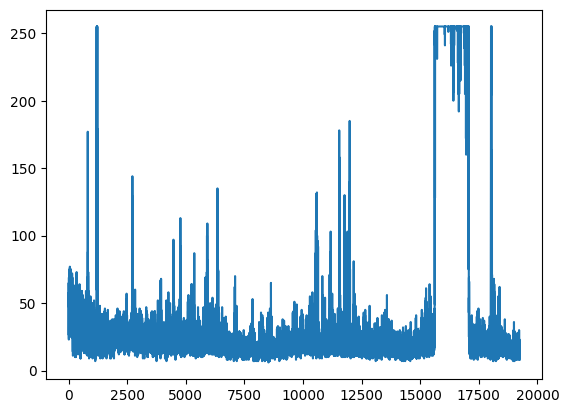

In [37]:
# Get Streams
def get_stream(
        rail_index,
        stream_id,
        length,
        data_size,
        data_position=0,
        system_id=SYSTEM,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_stream', {
            'streams': [{
                'system_id': system_id,
                'tube_id': rail_index,
                'stream_id': stream_id,
                'length': length,
                'data_size' : data_size,
                'data_position': data_position,
            }]
        }
    )
    if json_response['streams'][0]['status']:
        stream_data = data_client.receiveData()
        return list(bytearray(stream_data))
    else:
        raise TypeError(f'Retrieval of stream_id {stream_id} failed.')

stream = pd.Series(get_stream(**get_curves(2366)[3]['stream']))
stream.plot();

## Processing Signal to Noise Ratio
One of the objectives for this project is to be able to perform additional analysis which is not obtainable using the API aggregated information directly. By getting to the raw stream data additional features could be extracted which are important to overall understanding of the defects detected. One of these characteristics is the signal to noise ratio. 


In [38]:
def stream_stats(stream):
    if isinstance(stream, list):
        stream = pd.Series(stream)
    threshold = 0.8 * stream.max()
    signal_pts = stream.where(stream > threshold)
    noise_pts = stream.where(stream < threshold)

    signal_lvl = pd.Series(signal_pts.mean(), index=['Signal'])
    noise_lvl = pd.Series(noise_pts.median(), index=['Noise'])
    signal_noise = pd.Series(signal_lvl.loc['Signal'] / noise_lvl.loc['Noise'], index=['SNR'])
    
    return pd.concat([signal_lvl, noise_lvl, signal_noise])

stream_stats(stream)


Signal    254.282565
Noise      19.000000
SNR        13.383293
dtype: float64

<AxesSubplot: >

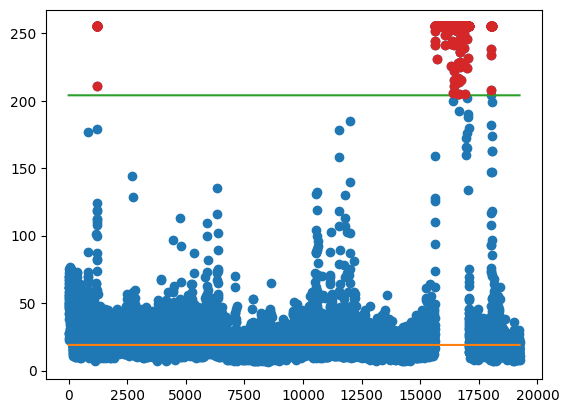

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)

threshold = .8 * max(stream)
signal = stream.where(stream> threshold)
noise = stream.where(stream<threshold)

stream.plot(ax=ax, style='o')
pd.Series(noise.median(), index=stream.index).plot(ax=ax)
pd.Series(threshold, index=stream.index).plot(ax=ax)
signal.plot(ax=ax, style='o')


## Defect Extractions
The equipment manufacturer has built in routines to determine and perform some characterization of defects. These values are logged for each piece scanned. There is a 1D and 2D scan for ultrasonic results. The 2D results do not appear to have been loaded into the the database, so only 1D is available. 

In [40]:
# Get Defects 1D UT
def get_defects_1d_ut(
        rail_index,
        system_id=SYSTEM,
        merge_type=0,
        merge_gates=False,
        **kwargs
):
    if (merge_type in range(1, 4)) and merge_gates:
        raise ValueError('Merge Gates only compatible with merge type `Global`(0)')

    json_response =  client.sendCommand(
        'get_defects_ut', {
            'tube_id': rail_index,
            'system_id': system_id,
            'merge_type': merge_type,
            'merge_gates': merge_gates,
        }
    )
    return json_response['defects']

def defects_1d_ut_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .join(channel_names.loc['UT'], on='channel_id')
        .rename(columns={'Name': 'channel_name'})
        .assign( # Create new columns by mapping global values
            mode=descriptor_df['mode_id'].map(MODE),
        )
    )

defect_1d_ut_df = defects_1d_ut_to_frame(get_defects_1d_ut(2366))
print(defect_1d_ut_df.info())
defect_1d_ut_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   alarm_id         433 non-null    int64  
 1   axial_length     433 non-null    float64
 2   axial_position   433 non-null    float64
 3   channel_id       433 non-null    int64  
 4   gate_id          433 non-null    int64  
 5   group_id         433 non-null    int64  
 6   mode_id          433 non-null    int64  
 7   radial_length    433 non-null    float64
 8   radial_position  433 non-null    float64
 9   submode_id       433 non-null    int64  
 10  channel_name     433 non-null    object 
dtypes: float64(4), int64(6), object(1)
memory usage: 37.3+ KB
None


,alarm_id,axial_length,axial_position,channel_id,gate_id,group_id,mode_id,radial_length,radial_position,submode_id,channel_name
0,1,5.6,11.200,3,1,0,11,0.0,0.0,1,HS1:BR
1,1,2.8,238.000,3,1,0,11,0.0,0.0,1,HS1:BR
2,1,2.8,282.800,4,1,0,11,0.0,0.0,2,HS2:ST
3,1,7.5,367.500,2,2,0,10,0.0,0.0,0,H2
4,1,9.6,374.399,1000,1,0,10,0.0,0.0,0,H1


In [41]:
# Get Defects 2D UT
def get_defects_2d_ut(
        rail_index,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_defects_2d_ut', {
            'tube_id': rail_index,
        }
    )
    return json_response['defects']

def defects_2d_ut_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .join(channel_names.loc['UT'], on='channel_id')
        .rename(columns={'Name': 'channel_name'})
    )
get_defects_2d_ut(2366)
#defect_2d_ut_df = defects_2d_ut_to_frame(get_defects_2d_ut(2366))
#print(defect_2d_ut_df.info())Santa Fe, New Mexico
#defect_2d_ut_df.head()

[]

Regarding Eddy Current, only 2D results are available. This code block also performs some additional manipulation to identifying the locations of the defects in 2D space. The raw data provides the corner coordinates of the defects. 

In [42]:
# Get Defects 2D EC
def get_defects_2d_ec(
        rail_index,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_defects_2d_ec', {
            'tube_id': rail_index,
        }
    )
    return json_response['defects']

def defects_2d_ec_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .drop(columns='coords')
        .join(channel_names.loc['EC'], on='channel_id')
        .replace({'data_type': DATA_TYPE}
        )
        .rename(columns={'Name': 'channel_name'})
    )

def defects_2d_coordinates_corners(defects):
    idx = ['bottom left', 'top left', 'top right', 'bottom right']
    df_l = [pd.DataFrame(defect['coords'], index=idx) for defect in defects]
    return pd.concat(df_l, keys=range(len(defects)))

def defects_2d_coordinates_extents(defects):
    cols = ['top', 'left', 'bottom', 'right']

    df_l = [(
        defect['coords'][1]['y'], #top
        defect['coords'][1]['x'], #left
        defect['coords'][3]['y'], #bottom
        defect['coords'][3]['x'], #right
        ) for defect in defects]
    return pd.DataFrame.from_records(df_l, columns=cols)

#def defects
defect_2d_ec_df = defects_2d_ec_to_frame(get_defects_2d_ec(2366))
print(defect_2d_ec_df.info())
defect_2d_ec_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alarm_id      345 non-null    int64  
 1   amplitude     345 non-null    float64
 2   channel_id    345 non-null    int64  
 3   data_type     345 non-null    object 
 4   group_id      345 non-null    int64  
 5   channel_name  345 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 16.3+ KB
None


,alarm_id,amplitude,channel_id,data_type,group_id,channel_name
0,1,-2.36,1,All,1,CHRS1:LT
1,1,4.14,1,All,1,CHRS1:LT
2,1,2.78,1,All,1,CHRS1:LT
3,1,-2.01,1,All,1,CHRS1:LT
4,1,-5.00,1,All,1,CHRS1:LT


The coordinate data can be split into a DataFrame representing 1 item to the four (many) corner coordinates. 

In [44]:
defects_2d_coordinates_corners(get_defects_2d_ec(2366)).head(10)

x     y
0 bottom left   437.0  60.0
  top left      437.0  64.0
  top right     440.0  64.0
  bottom right  440.0  60.0
1 bottom left   441.0  64.0
  top left      441.0  68.0
  top right     446.0  68.0
  bottom right  446.0  64.0
2 bottom left   442.0  55.0
  top left      442.0  59.0

I think what will be more usable in the future is understanding the extents of the defect, and this provides a single record for each rail instead of a one to many relationship. 

In [86]:
defects_2d_coordinates_extents(get_defects_2d_ec(2366)).head(10)

,top,left,bottom,right
0,64.0,437.0,60.0,440.0
1,68.0,441.0,64.0,446.0
2,59.0,442.0,55.0,446.0
3,64.0,449.0,60.0,450.0
4,68.0,539.0,21.0,550.0
5,64.0,851.0,60.0,855.0
6,64.0,1072.0,60.0,1086.0
7,42.0,2073.0,34.0,2078.0
8,38.0,2528.0,34.0,2537.0
9,67.0,2983.0,55.0,2988.0


In [79]:
# Get calibration defects, currently not operational in API
#def get_setup_calibration_defects_ut(
#    calibration_product,
#    setup_id,
#    system_id=0,
#):
#    json_response = client.sendCommand(
#        'get_setup_calibration_defects_ut', {
#            'system_id': system_id,
#            'calibration_product': calibration_product,
#            'setup_id': setup_id
#        }
#    )
#    return json_response['defects']
#
#cal_defects = get_setup_calibration_defects_ut('Rail 136 Prove Up', 27)
#cal_defects

IN CURVE L2 TABLE NEED 
| rail_ID | inspection timestamp | rail_index |
|---|---|---|

# action plan
* extract data which would be present in L2
* Load to L2
* Pull back down from L2
* Query stream data
* Run analysis

# Extract Defect Data

In [45]:
# Get all Orders
orders = get_order_list()
orders

['RAIL 136 PROVE UP FINAL', 'ORDER TEST']

In [46]:
# Get all Batches
ord_batch = []
for order in orders:
    for batch in get_batch_list(order):
        ord_batch.append((order, batch))
ord_batch

[('RAIL 136 PROVE UP FINAL', 'Test systeme'),
 ('RAIL 136 PROVE UP FINAL', 'Repetabilite')]

In [47]:
# Get all rail meta data
rails = []
for order, batch in ord_batch:
    rail_lst = get_rail_list(order, batch)
    #Insert order and batch information into rail
    # https://stackoverflow.com/questions/1781571/how-to-concatenate-two-dictionaries-to-create-a-new-one
    rail_lst = [dict({'order': order, 'batch': batch}, **rail) 
        for rail in rail_lst]
    # Flatten rail list
    rails += rail_lst

rail_df = pd.DataFrame(rails)
print(f'Total number of Rails {len(rails)}')


Total number of Rails 72


In [48]:
# Get all rails
defects_1d_ut_raw = pd.concat(
    [ # list comprehension over all rails
        (
            defects_1d_ut_to_frame( # Convert defects
                get_defects_1d_ut(rail) # get defect dictionaries
            )
            .drop_duplicates()
        )
            for rail in rail_df['db_index']
    ],
    axis=0,
    keys=rail_df[['order', 'batch', 'db_index']].itertuples(index=False),
    names=['order', 'batch', 'db_index', 'sequence'],
    #ignore_index=True
)
#defects_1d_ut.index.set_names
defects_1d_ut_raw.head(20)

alarm_id  \
order                   batch        db_index sequence             
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1   
                                              1                1   
                                              2                1   
                                              3                1   
                                              4                1   
                                              5                1   
                                              6                1   
                                              7                1   
                                              17               1   
                                              21               1   
                                              28               1   
                                              29               1   
                                              30               1   
                                              31               1   
                                              32               1   
                                              33               1   
                                              40               1   
                                              47               1   
                                              48               1   
                                              49               1   

                                                        axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     0                5.600   
                                              1                2.800   
                                              2                2.800   
                                              3                7.500   
                                              4                9.600   
                                              5                9.600   
                                              6                9.600   
                                              7                7.200   
                                              17               7.200   
                                              21               9.600   
                                              28               4.799   
                                              29               7.199   
                                              30               7.199   
                                              31               4.799   
                                              32               7.500   
                                              33              11.999   
                                              40               9.600   
                                              47               7.500   
                                              48              10.000   
                                              49              12.500   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0                 11.200   
                                              1                238.000   
                                              2                282.800   
                                              3                367.500   
                                              4                374.399   
                                              5                374.399   
                                              6                376.799   
                                              7                376.799   
                                              17               376.799   
                                              21               376.799   
                                              28               379.200   
            

In [55]:
# Get all rail defects
rail_defects = [get_defects_2d_ec(rail) for rail in rail_df['db_index']]

In [53]:
# Confirm all 2D coordinates are rectangles
def rectangle_defects_2d_coordinates(defects):
    cols = ['top', 'left', 'bottom', 'right']
    #['bottom left', 'top left', 'top right', 'bottom right']
    df_l = [(# Compare corner coordinates
        defect['coords'][1]['y'] == defect['coords'][2]['y'], #top
        defect['coords'][0]['x'] == defect['coords'][1]['x'], #left
        defect['coords'][0]['y'] == defect['coords'][3]['y'], #bottom
        defect['coords'][2]['x'] == defect['coords'][3]['x'], #right
        ) for defect in defects]
    return pd.DataFrame.from_records(df_l, columns=cols)

(
    pd.concat(
        [rectangle_defects_2d_coordinates(rail) for rail in rail_defects]
    )
    .all(axis=None) # Check all values are true
)

True

All sides of the corners are the same values, so the defective area is a rectangle.

Now all of the data can be pulled together into a single data source, for 2D data.

In [54]:
# Compiled data for Eddy Current

defects_2d_ec_raw = pd.concat(
    [ # list comprehension of transformation functions
        (
            defects_2d_ec_to_frame(rail)
            .join(defects_2d_coordinates_extents(rail))
            .drop_duplicates()
        )
            for rail in rail_defects
    ],
    axis=0,
    keys=rail_df[['order', 'batch', 'db_index']].itertuples(index=False),
    names=['order', 'batch', 'db_index', 'sequence'],
)

defects_2d_ec_raw.head(20)

alarm_id  amplitude  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1      -2.36   
                                              1                1       4.14   
                                              2                1       2.78   
                                              3                1      -2.01   
                                              4                1      -5.00   
                                              5                1      -2.52   
                                              6                1       3.97   
                                              7                1      -2.49   
                                              8                1       2.64   
                                              9                1      -3.53   
                                              10               1       3.00   
                                              11               1       5.00   
                                              12               1      -3.99   
                                              13               1       5.00   
                                              14               1       2.03   
                                              15               1       3.08   
                                              16               1      -5.00   
                                              17               1       3.50   
                                              18               1      -2.12   
                                              19               1       3.99   

                                                        channel_id data_type  \
order                   batch        db_index sequence                         
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  1       All   
                                              1                  1       All   
                                              2                  1       All   
                                              3                  1       All   
                                              4                  1       All   
                                              5                  1       All   
                                              6                  1       All   
                                              7                  1       All   
                                              8                  1       All   
                                              9                  1       All   
                                              10                 1       All   
                                              11                 1       All   
                                              12                 1       All   
                                              13                 1       All   
                                              14                 1       All   
                                              15                 1       All   
                                              16                 1       All   
                                              17                 1       All   
                                              18                 1       All   
                                              19                 1       All   

                                                        group_id channel_name  \
order                   batch        db_index sequence                          
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1     CHRS1:LT   
                                              1                1     CHRS1:LT   
                                              2                1     CHRS1:LT   
                                              3                1     CHRS1:LT   
                                              4                1     C

# Back Up Data to Local DB

In [1]:
local_db = 'local_backup.db'

In [25]:
import sqlite3

con = sqlite3.connect(local_db)
# Perform uploads, and replace with newer data
ut_rows = defects_1d_ut_raw.to_sql('UT', con, if_exists='replace')
ec_rows = defects_2d_ec_raw.to_sql('EC', con, if_exists='replace')

f'Records uploaded: Ultrasonic {ut_rows}, ' +\
    f'Eddy Current {ec_rows}'


'Records uploaded: Ultrasonic 16245, Eddy Current 24438'

# Retrieve from Local DB

In [2]:
import sqlite3 # for getting backed up up data
import pandas as pd # This will be a common starting point with a kernel reset
import matplotlib.pyplot as plt

import seaborn as sns

# Connect to the database
con = sqlite3.connect(local_db)
# Retrieve NTM, set index and parse dates
sql = 'Select * FROM UT'
defects_1d_ut_raw = pd.read_sql(sql, con).set_index(
    ['order', 'batch', 'db_index', 'sequence']
)

# Retrieve waterbox, set index and parse dates
sql = 'Select * FROM EC'
defects_2d_ec_raw = pd.read_sql(sql, con).set_index(
    ['order', 'batch', 'db_index', 'sequence']
)

f'Records retrieved: Ultrasonic {defects_1d_ut_raw.shape}, ' +\
    f'Eddy Current {defects_2d_ec_raw.shape}'

'Records retrieved: Ultrasonic (16245, 11), Eddy Current (24438, 10)'

# EDA Ultrasonic

In [3]:
# Recap of data results
print(defects_1d_ut_raw.info())
defects_1d_ut_raw.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16245 entries, ('RAIL 136 PROVE UP FINAL', 'Test systeme', 2366, 0) to ('RAIL 136 PROVE UP FINAL', 'Repetabilite', 2373, 561)
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   alarm_id         16245 non-null  int64  
 1   axial_length     16245 non-null  float64
 2   axial_position   16245 non-null  float64
 3   channel_id       16245 non-null  int64  
 4   gate_id          16245 non-null  int64  
 5   group_id         16245 non-null  int64  
 6   mode_id          16245 non-null  int64  
 7   radial_length    16245 non-null  float64
 8   radial_position  16245 non-null  float64
 9   submode_id       16245 non-null  int64  
 10  channel_name     16245 non-null  object 
dtypes: float64(4), int64(6), object(1)
memory usage: 1.5+ MB
None


alarm_id  \
order                   batch        db_index sequence             
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1   
                                              1                1   
                                              2                1   
                                              3                1   
                                              4                1   

                                                        axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  5.6   
                                              1                  2.8   
                                              2                  2.8   
                                              3                  7.5   
                                              4                  9.6   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0                 11.200   
                                              1                238.000   
                                              2                282.800   
                                              3                367.500   
                                              4                374.399   

                                                        channel_id  gate_id  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  3        1   
                                              1                  3        1   
                                              2                  4        1   
                                              3                  2        2   
                                              4               1000        1   

                                                        group_id  mode_id  \
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     0                0       11   
                                              1                0       11   
                                              2                0       11   
                                              3                0       10   
                                              4                0       10   

                                                        radial_length  \
order                   batch        db_index sequence                  
RAIL 136 PROVE UP FINAL Test systeme 2366     0                   0.0   
                                              1                   0.0   
                                              2                   0.0   
                                              3                   0.0   
                                              4                   0.0   

                                                        radial_position  \
order                   batch        db_index sequence                    
RAIL 136 PROVE UP FINAL Test systeme 2366     0                     0.0   
                                              1                     0.0   
                                              2                     0.0   
                                              3                     0.0   
                                              4                     0.0   

                                                        submode_id  \
order                   batch        db_index sequence               
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  1   
                                              1                  1   
                                              2                  2   
                                              3                  0   
   

## Exploring Variation in UT Data
Scanning through the data, I want to confirm that the test data does have variation, and isn't the exact same data set repeated multiple times. First I want to 

In [4]:
# Confirming some variation in the data, it isn't duplicated
defects_1d_ut_raw.alarm_id.groupby(level=[1, 2]).count()


batch         db_index
Repetabilite  248         238
              249         306
              250         217
              251         215
              252         209
                         ... 
Test systeme  3388        222
              3389        217
              3390        276
              3391        226
              3392        212
Name: alarm_id, Length: 72, dtype: int64

In [5]:
defects_1d_ut_raw.describe()

,alarm_id,axial_length,axial_position,channel_id,gate_id,group_id,mode_id,radial_length,radial_position,submode_id
count,16245.0,16245.000000,16245.000000,16245.000000,16245.000000,16245.0,16245.000000,16245.0,16245.0,16245.000000
mean,1.0,52.103541,3910.845747,641.549277,1.243460,0.0,10.779440,0.0,0.0,0.801354
std,0.0,173.165001,2052.133608,478.296570,0.429183,0.0,1.006466,0.0,0.0,0.906282
min,1.0,2.000000,0.000000,2.000000,1.000000,0.0,10.000000,0.0,0.0,0.000000
25%,1.0,4.800000,3180.000000,4.000000,1.000000,0.0,10.000000,0.0,0.0,0.000000
50%,1.0,7.201000,4400.000000,1000.000000,1.000000,0.0,10.000000,0.0,0.0,0.000000
75%,1.0,11.200000,5471.999000,1000.000000,1.000000,0.0,11.000000,0.0,0.0,2.000000
max,1.0,6727.500000,6735.000000,1001.000000,2.000000,0.0,14.000000,0.0,0.0,2.000000


Alarm ID, Group ID, Radial Length, and Radial Position have no variation, a constant value. These columns can be removed from the data set. Next if I remove the axial length and position, temporarily, I want to see how many sensor configurations are used. Dropping duplicates will show unique combinations.

In [6]:
defects_1d_ut_raw[[
       #'alarm_id', 
       #'axial_length', 
       #'axial_position', 
       'channel_id', 
       'gate_id',
       #'group_id', 
       'mode_id', 
       #'radial_length', 
       #'radial_position', 
       'submode_id',
       'channel_name'
]].drop_duplicates().sort_values(['channel_name', 'gate_id'])

channel_id  gate_id  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     82                10        1   
                                              240               11        1   
                                              4               1000        1   
                                              5               1000        2   
                                              149                2        1   
                                              3                  2        2   
                                              0                  3        1   
                                              2                  4        1   
                                              263                5        1   
                                              47              1001        1   

                                                        mode_id  submode_id  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     82             14           1   
                                              240            14           2   
                                              4              10           0   
                                              5              10           0   
                                              149            10           0   
                                              3              10           0   
                                              0              11           1   
                                              2              11           2   
                                              263            12           2   
                                              47             12           2   

                                                       channel_name  
order                   batch        db_index sequence               
RAIL 136 PROVE UP FINAL Test systeme 2366     82              B1:BR  
                                              240             B2:ST  
                                              4                  H1  
                                              5                  H1  
                                              149                H2  
                                              3                  H2  
                                              0              HS1:BR  
                                              2              HS2:ST  
                                              263             W1:ST  
                                              47              W2:ST

There are only 10 sensor unique combinations. The channel_name/channel_id and gate_id is a unique combination. This combined ID in conjunction with the axial length and position would provide a simplified data set. 

In [7]:
defects_1d_ut = (
    defects_1d_ut_raw
    .assign(
        channel=defects_1d_ut_raw['channel_name'] \
            + '-' \
            + defects_1d_ut_raw['gate_id'].astype(str),
    )
)[['axial_length', 'axial_position', 'channel']]
defects_1d_ut.head()

axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  5.6   
                                              1                  2.8   
                                              2                  2.8   
                                              3                  7.5   
                                              4                  9.6   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0                 11.200   
                                              1                238.000   
                                              2                282.800   
                                              3                367.500   
                                              4                374.399   

                                                         channel  
order                   batch        db_index sequence            
RAIL 136 PROVE UP FINAL Test systeme 2366     0         HS1:BR-1  
                                              1         HS1:BR-1  
                                              2         HS2:ST-1  
                                              3             H2-2  
                                              4             H1-1

Visualization of the defect points. splitting by the two batches.

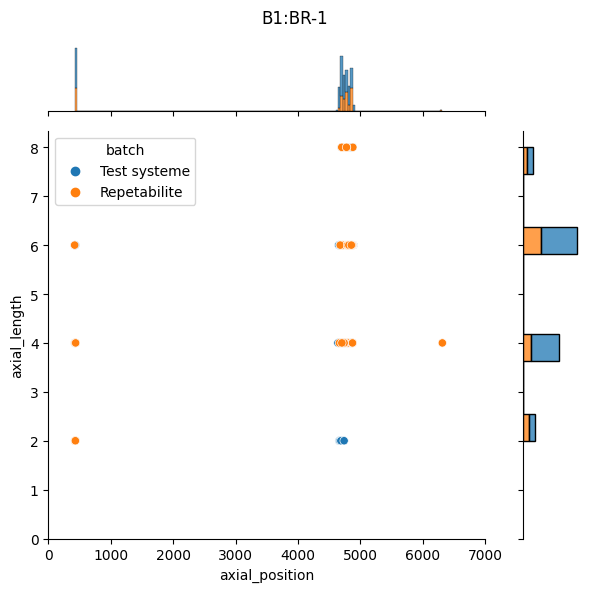

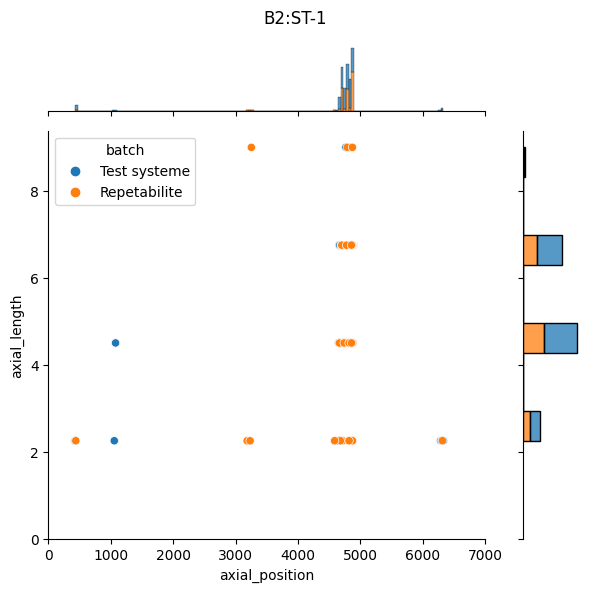

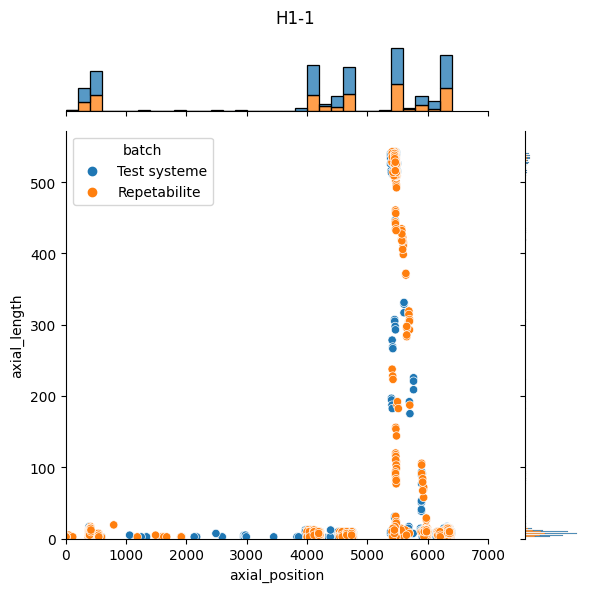

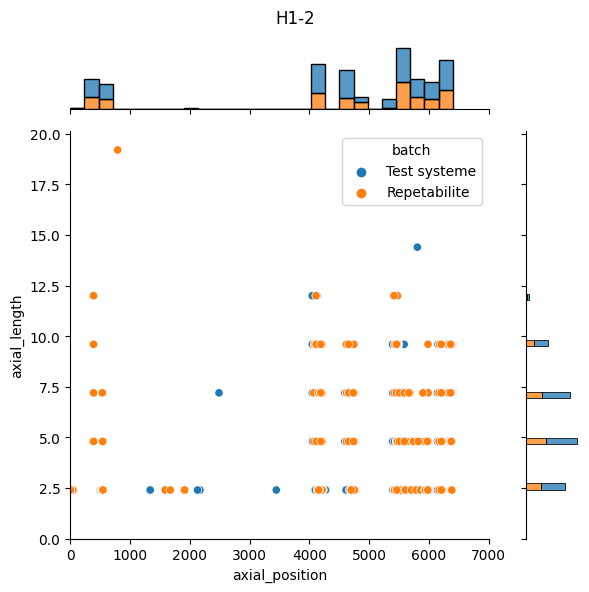

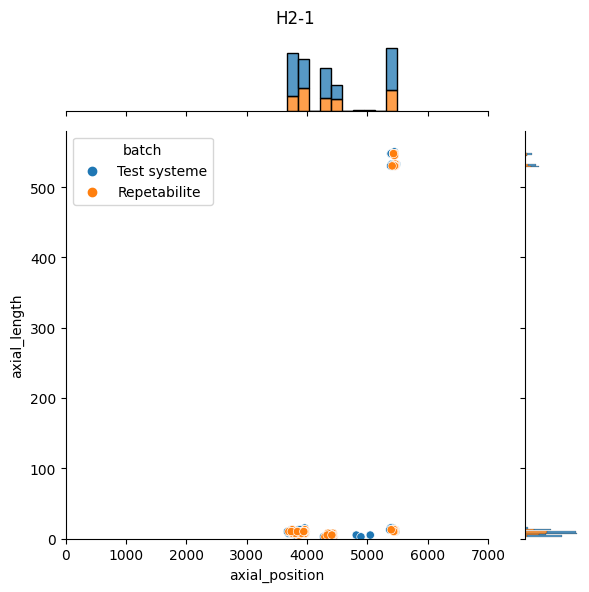

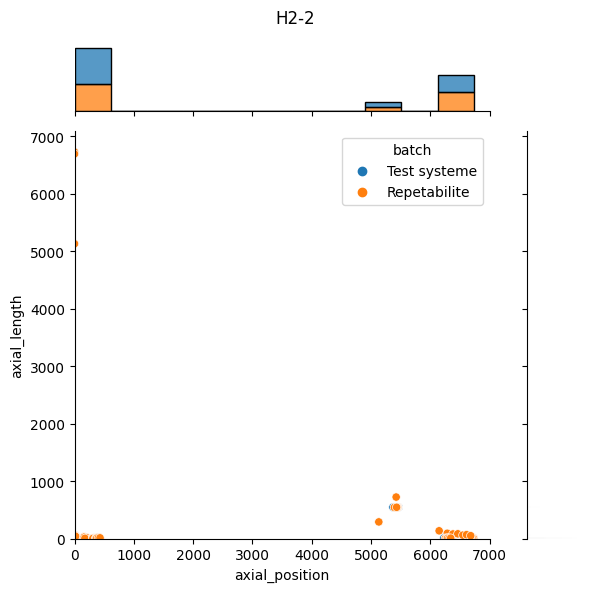

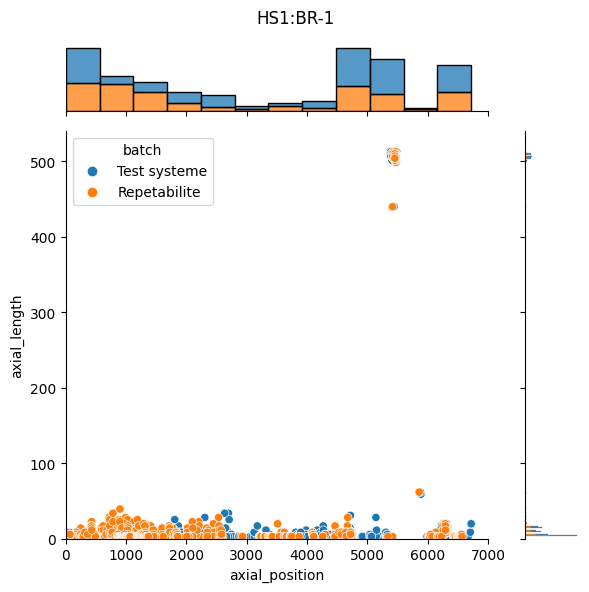

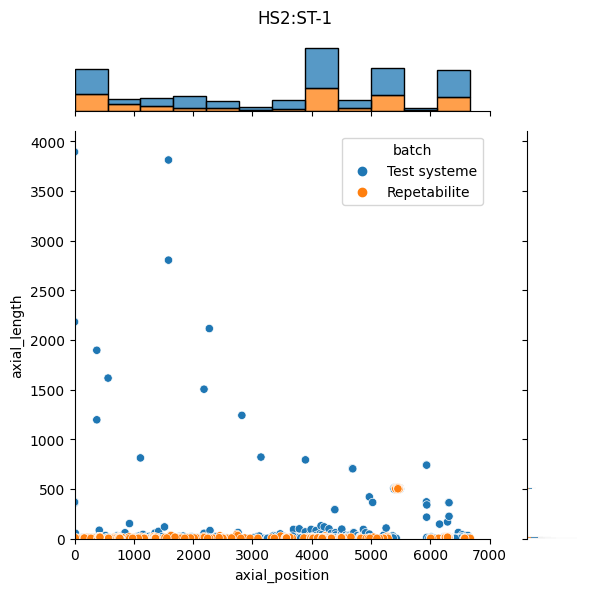

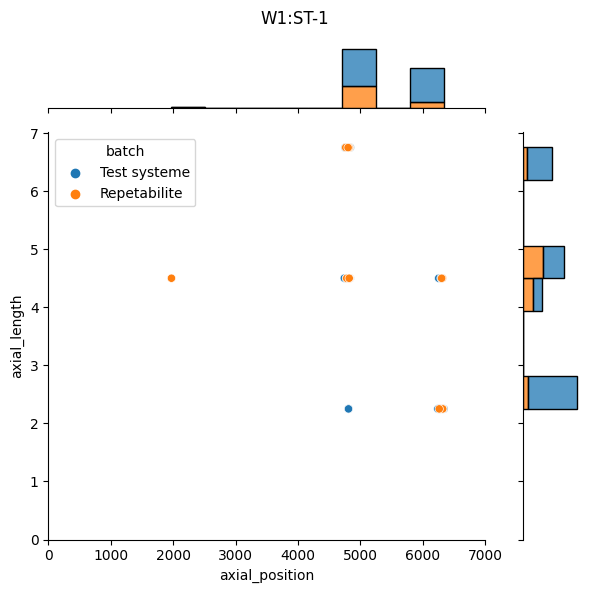

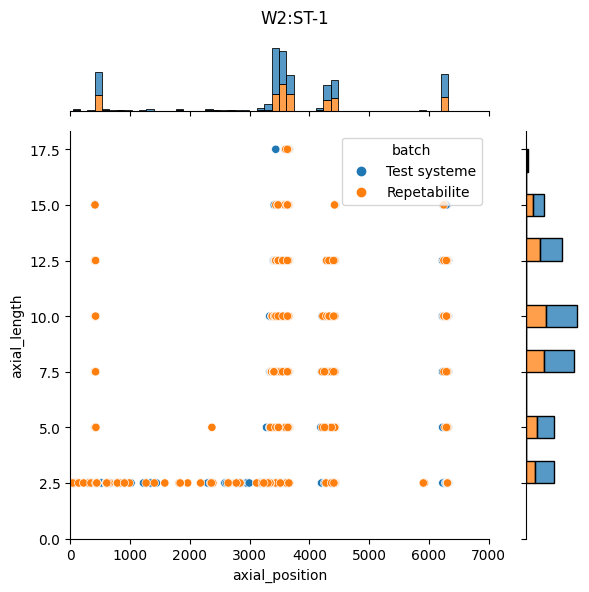

In [8]:
for channel, df in defects_1d_ut.groupby('channel'):
    # Set defaults
    df = df.reset_index()
    x='axial_position'
    y='axial_length'
    hue='batch'
    
    g = sns.JointGrid() # Create the joint plot
    # plot x y data as main data
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        hue=hue, 
        ax=g.ax_joint
    )
    # Add distributions, stacked & split by batch run
    sns.histplot(
        data=df, 
        x=x, 
        hue=hue, 
        multiple='stack', 
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=df,
        y=y,
        hue=hue,
        multiple='stack',
        legend=False,
        ax=g.ax_marg_y,
    )

    #g.plot(sns.scatterplot, sns.histplot)
    g.ax_joint.set_xlim((0,7000))
    ymax = g.ax_joint.get_ylim()[1]
    g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
    g.figure.suptitle(f'{channel}')
    g.figure.tight_layout()

Zoom in on one indication to see how much spread is present. 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 140 entries, ('RAIL 136 PROVE UP FINAL', 'Test systeme', 2366, 239) to ('RAIL 136 PROVE UP FINAL', 'Repetabilite', 2373, 358)
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   axial_length    140 non-null    float64
 1   axial_position  140 non-null    float64
dtypes: float64(2)
memory usage: 26.8+ KB
None


axial_length  axial_position
order                   batch        sequence                              
RAIL 136 PROVE UP FINAL Test systeme 242                6.0          4722.0
                                     261                6.0          4796.0
                                     264                6.0          4874.0

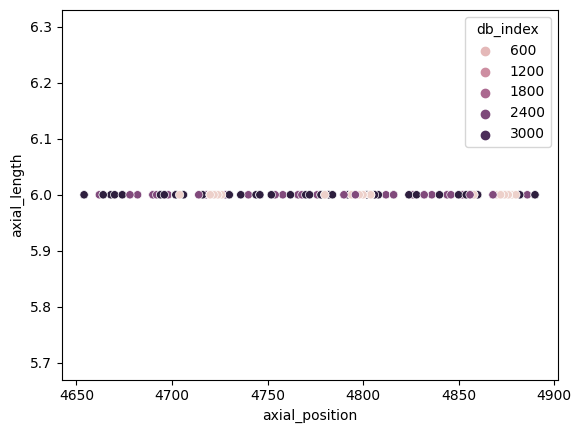

In [142]:
displacements = defects_1d_ut.loc[
    (defects_1d_ut['channel'] == 'B1:BR-1') &
    (defects_1d_ut['axial_position'] > 4000) & 
    (defects_1d_ut['axial_position'] < 5000) & 
    (defects_1d_ut['axial_length'] == 6.0),
    ['axial_length', 'axial_position']
    ]
sns.scatterplot(
    data=displacements, 
    x='axial_position', 
    y='axial_length', 
    hue=displacements.index.get_level_values('db_index')
)
print(displacements.info())
displacements.loc[(slice(None), slice(None), 3392)]

One target has 140 values for only 72 pieces. There are some duplicates, as shown by looking at ID 3392. Indication positions also have a large range (240 mm) for a single target. 

Another observation is the precision of the axial length; the values for channel 'B1:BR-1' in the axial channel are too exact (multiples of 2) and don't match logical positions relative to the prints. My initial assumption that these values are coordinates relative to a datum is likely incorrect. Additionally, what axial length represents may be channel specific.

!!!!!! UT Conclusion for EDA.....

# Separate Known UT Targets
Amount of spread is surprising. The axial length value is not a y position. Additional review of how equipment works needs to be determined To interpret the axial length value

In [145]:
import numpy as np

defects_1d_ut_classified = defects_1d_ut.copy()
defects_1d_ut_classified['target_id'] = np.nan

for channel in defects_1d_ut_classified['channel'].unique():
    try:
        targets = target_locations.loc[
            channel, 
            ['axial_location', 'pre', 'post']
        ]
    except KeyError:
        print(f'Channel {channel} not found in target list')
        continue
    for idx, target in targets.iterrows():
        defects_1d_ut_classified.loc[ 
            (defects_1d_ut_classified['channel'] == channel) &
            (defects_1d_ut_classified['axial_position'] > target['pre']) &
            (defects_1d_ut_classified['axial_position'] < target['post'])
            ,
            'target_id'
        ] = target['axial_location']

defects_1d_ut_classified.dropna(subset='target_id')

Channel HS2:ST-1 not found in target list


axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     149             12.500   
                                              150             12.500   
                                              152             15.000   
                                              194              5.000   
                                              196              5.000   
...                                                              ...   
                        Repetabilite 2373     409              4.801   
                                              410              7.200   
                                              412              4.799   
                                              413              4.801   
                                              415              7.200   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     149             3752.500   
                                              150             3857.500   
                                              152             3960.000   
                                              194             4267.500   
                                              196             4270.000   
...                                                                ...   
                        Repetabilite 2373     409             5587.199   
                                              410             5664.000   
                                              412             5743.200   
                                              413             5819.999   
                                              415             5896.800   

                                                        channel  target_id  
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     149          H2-1      116.0  
                                              150          H2-1      108.0  
                                              152          H2-1      108.0  
                                              194       W2:ST-1       96.0  
                                              196       W2:ST-1       96.0  
...                                                         ...        ...  
                        Repetabilite 2373     409          H1-2       45.0  
                                              410          H1-2       42.0  
                                              412          H1-2       39.0  
                                              413          H1-2       36.0  
                                              415          H1-2       33.0  

[3673 rows x 4 columns]

Channel HS2:ST-1 not found in target list


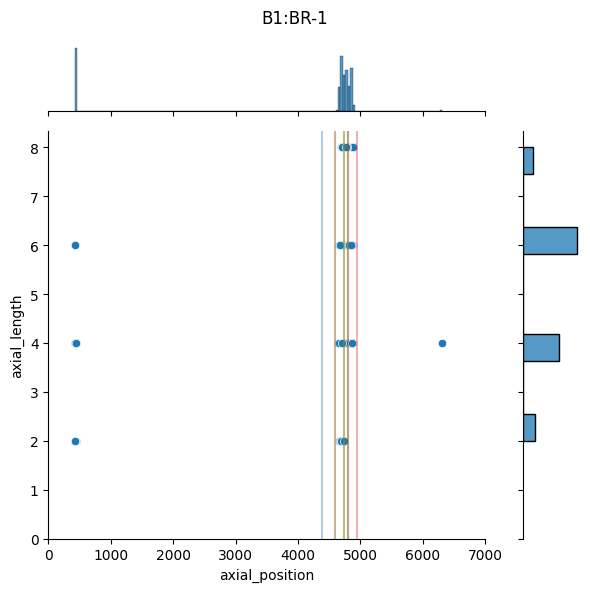

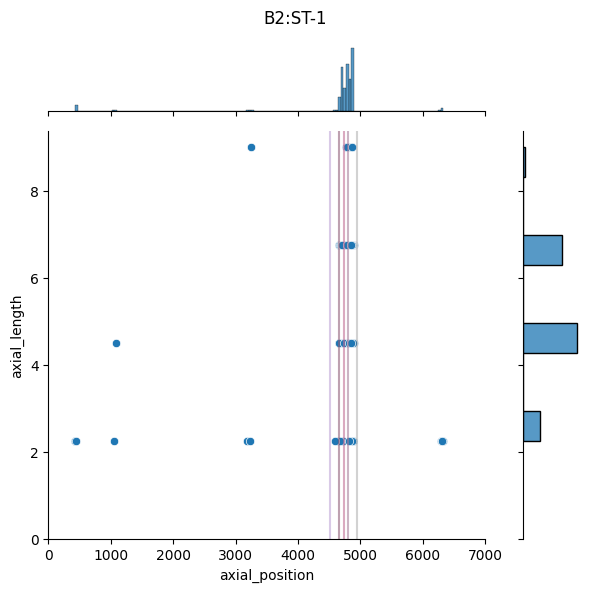

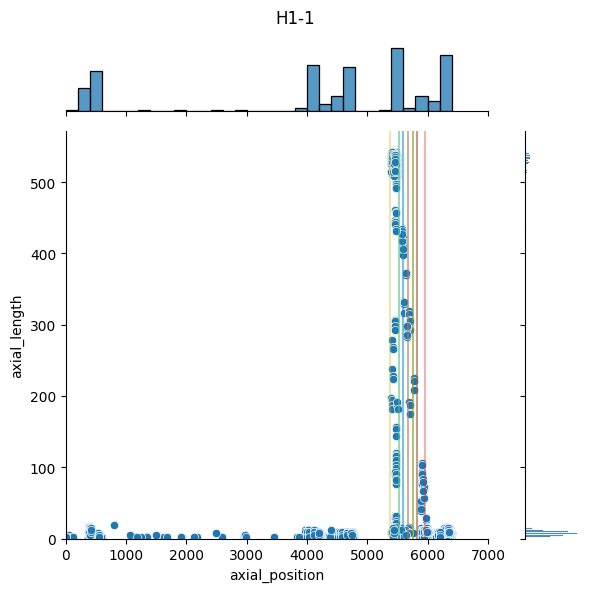

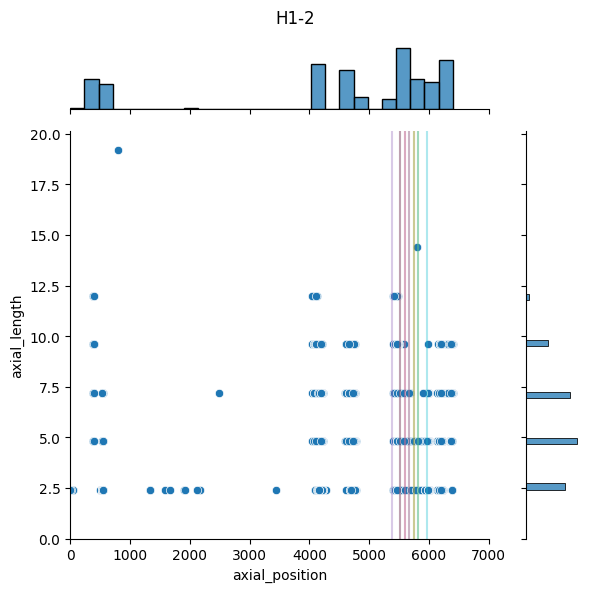

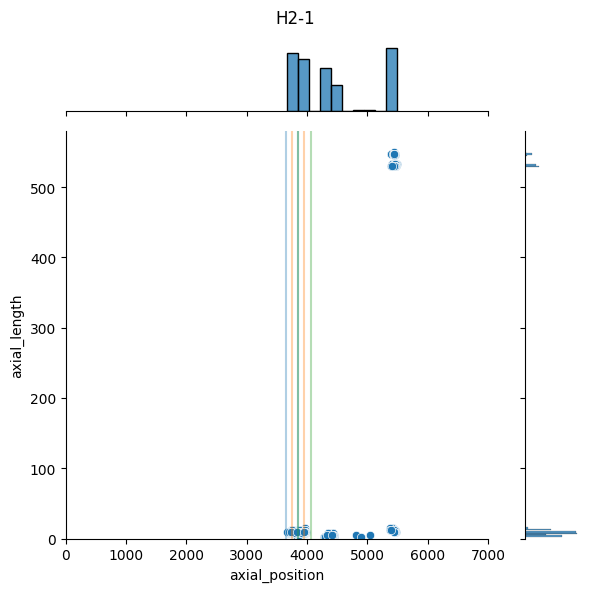

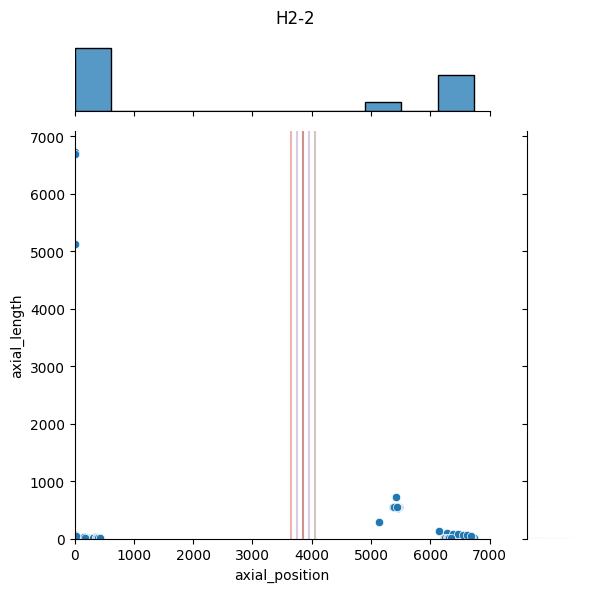

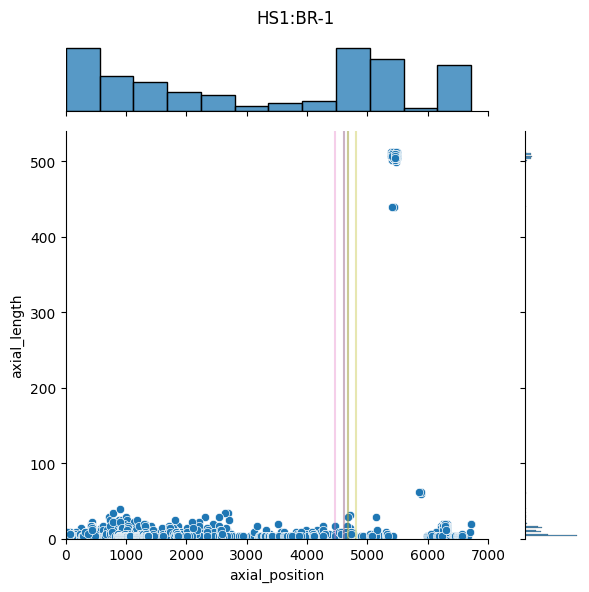

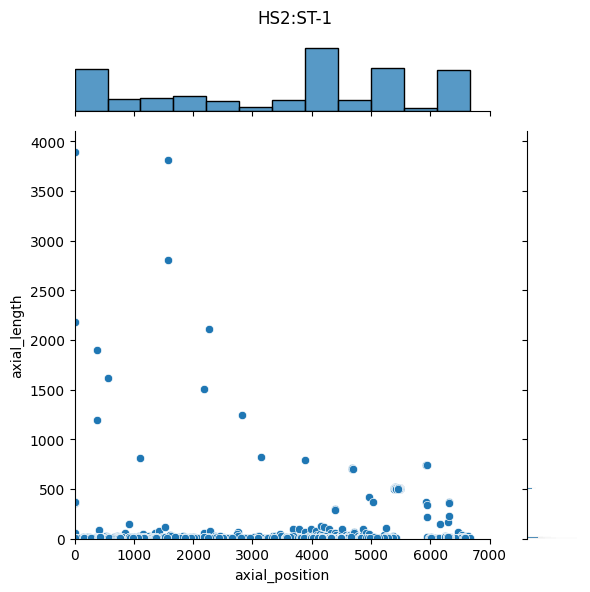

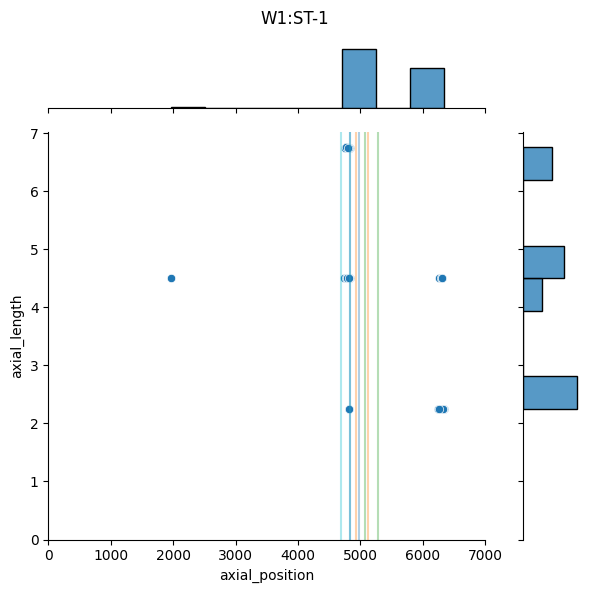

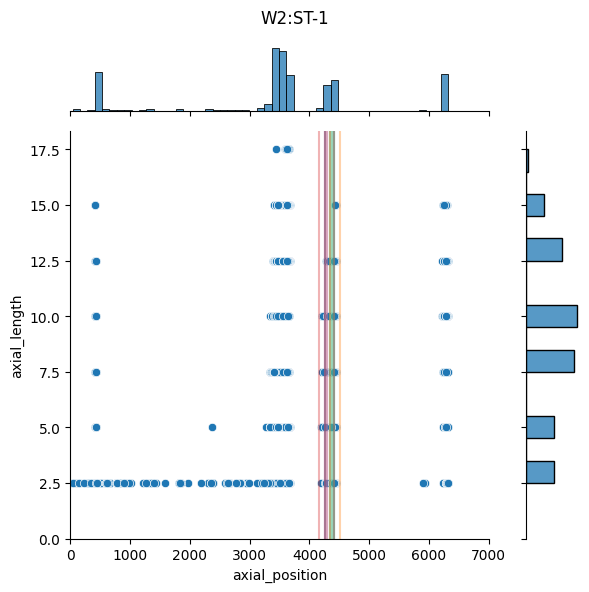

In [147]:
# color cycler from https://stackoverflow.com/questions/28430385/seaborn-cycle-through-colours-with-matplotlib-scatter
from itertools import cycle
palette = cycle(sns.color_palette())

for channel, df in defects_1d_ut.groupby('channel'):
    # Set defaults
    df = df.reset_index()
    x='axial_position'
    y='axial_length'
    
    g = sns.JointGrid() # Create the joint plot
    # plot x y data as main data
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        #hue='amplitude', 
        ax=g.ax_joint
    )
    try:
        targets = target_locations.loc[channel, ['pre', 'post']]
        for idx, target in targets.iterrows():
            color=next(palette)
            g.ax_joint.axvline(target['pre'], alpha=.35, color=color)
            g.ax_joint.axvline(target['post'], alpha=.35, color=color)
    except KeyError:
        print(f'Channel {channel} not found in target list')

    sns.histplot(
        data=df, 
        x=x, 
        #hue=hue, 
        multiple='stack', 
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=df,
        y=y,
        #hue=hue,
        multiple='stack',
        legend=False,
        ax=g.ax_marg_y,
    )

    #g.plot(sns.scatterplot, sns.histplot)
    g.ax_joint.set_xlim((0,7000))
    ymax = g.ax_joint.get_ylim()[1]
    g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
    g.figure.suptitle(f'{channel}')
    g.figure.tight_layout()

group by channel and , count indications need at least one, flag if zero

In [150]:
defects_1d_ut_counts = (
    defects_1d_ut_classified
    .dropna()
    .reset_index(level='db_index')
    .groupby(
        ['db_index', 'channel', 'target_id']
    )
    ['axial_position']
    .count()
    .rename('count')
)
defects_1d_ut_counts

db_index  channel   target_id
248       B1:BR-1   73.0         1
                    76.0         1
                    79.0         1
          B2:ST-1   73.0         2
                    76.0         1
                                ..
3392      HS1:BR-1  84.0         1
          W1:ST-1   75.0         1
          W2:ST-1   90.0         2
                    93.0         3
                    96.0         2
Name: count, Length: 1626, dtype: int64

In [152]:
ut_targets = (
    target_locations
    .loc[
        target_locations['inspection_equipment'] == 'UT'
        , 'axial_location'
    ]
    .rename('target_id')
    .droplevel(-1)
    .reset_index()
)
ut_targets['count'] = 0
ut_targets = ut_targets.set_index(['channel', 'target_id'])

In [160]:
db_indexes = (
    defects_1d_ut_counts
    .index.
    get_level_values('db_index')
    .unique()
)

rails = []
for rail in db_indexes:
    df = ut_targets.copy()
    df.update(defects_1d_ut_counts.loc[rail])
    rails.append(df)

ut_counts = pd.concat(rails, keys=db_indexes)
ut_counts.head(20)

count
db_index channel target_id       
248      B1:BR-1 87.0         0.0
                 79.0         1.0
                 76.0         1.0
                 73.0         1.0
         B2:ST-1 82.0         0.0
                 79.0         1.0
                 76.0         1.0
                 73.0         2.0
         H1-1    48.0        15.0
                 45.0         0.0
                 42.0         0.0
                 39.0         5.0
                 36.0         0.0
                 33.0         0.0
         H1-2    48.0         3.0
                 45.0         2.0
                 42.0         2.0
                 39.0         2.0
                 36.0         1.0
                 33.0         3.0

FIND CHANNELS WHICH HAVE NO RESULTS

In [161]:
ut_misses = ut_counts[(ut_counts == 0)].dropna().reset_index()
#ut_misses = ut_misses[ut_misses['channel'] != ':OB']
ut_misses

,db_index,channel,target_id,count
0,248,B1:BR-1,87.0,0.0
1,248,B2:ST-1,82.0,0.0
2,248,H1-1,45.0,0.0
3,248,H1-1,42.0,0.0
4,248,H1-1,36.0,0.0
...,...,...,...,...
1197,3392,HS1:ST-1,102.0,0.0
1198,3392,HS1:ST-1,99.0,0.0
1199,3392,W1:ST-1,72.0,0.0
1200,3392,W1:ST-1,66.0,0.0


In [155]:
ut_miss_counts = ut_misses.groupby(['channel', 'target_id'])['count'].count()
ut_miss_counts

channel   target_id
B1:BR-1   73.0          2
          76.0          1
          79.0          3
          87.0         72
B2:ST-1   73.0          1
          76.0          1
          79.0          4
          82.0         68
H1-1      33.0         49
          36.0         71
          39.0         67
          42.0         69
          45.0         67
H1-2      36.0          1
          39.0          1
H2-1      108.0         3
          112.0         7
          116.0        28
H2-2      108.0        72
          112.0        72
          116.0        72
HS1:BR-1  78.0          4
          81.0          5
HS1:ST-1  99.0         72
          102.0        72
          105.0        72
W1:ST-1   60.0         72
          66.0         72
          72.0         69
          75.0          3
W2:ST-1   90.0         30
Name: count, dtype: int64

There are many targets which were not identified on any of the test runs. I'll print them out but will exclude them from future review. The company is likely trying to improve sensitivity. One target was missed by all test runs but one. This likely is a false positive, so a 95% confidence was added to the exclusion

In [157]:
ut_always_miss = (
    ut_miss_counts
    [ut_miss_counts > 0.95 * len(db_indexes)]
    .index
    .unique()
    #.to_frame()
)
ut_always_miss

MultiIndex([( 'B1:BR-1',  87.0),
            (    'H1-1',  36.0),
            (    'H1-1',  42.0),
            (    'H2-2', 108.0),
            (    'H2-2', 112.0),
            (    'H2-2', 116.0),
            ('HS1:ST-1',  99.0),
            ('HS1:ST-1', 102.0),
            ('HS1:ST-1', 105.0),
            ( 'W1:ST-1',  60.0),
            ( 'W1:ST-1',  66.0),
            ( 'W1:ST-1',  72.0)],
           names=['channel', 'target_id'])

In [158]:
ut_miss_counts = ut_miss_counts[ut_miss_counts < 0.95 * len(db_indexes)]
miss_rate = ut_miss_counts/len(db_indexes)
miss_rate

channel   target_id
B1:BR-1   73.0         0.027778
          76.0         0.013889
          79.0         0.041667
B2:ST-1   73.0         0.013889
          76.0         0.013889
          79.0         0.055556
          82.0         0.944444
H1-1      33.0         0.680556
          39.0         0.930556
          45.0         0.930556
H1-2      36.0         0.013889
          39.0         0.013889
H2-1      108.0        0.041667
          112.0        0.097222
          116.0        0.388889
HS1:BR-1  78.0         0.055556
          81.0         0.069444
W1:ST-1   75.0         0.041667
W2:ST-1   90.0         0.416667
Name: count, dtype: float64

In [159]:
(
    ut_counts
    .reset_index('db_index')
    .loc[
        ~ut_counts.reset_index('db_index').index.isin(ut_always_miss) &
        (ut_counts['count'] == 0).to_numpy() &
        (ut_counts.index.get_level_values('channel') != ':OB'),
        'db_index'
    ]
    .reset_index()
    .set_index('db_index')
)

,channel,target_id
db_index,,
248,B2:ST-1,82.0
248,H1-1,45.0
248,H1-1,33.0
248,H2-1,116.0
249,B2:ST-1,82.0
...,...,...
3392,B2:ST-1,82.0
3392,H1-1,45.0
3392,H1-1,39.0


# EDA Eddy Current
## Exploring Variation in EC Data
Just like with the ultrasonic data, I want to confirm that the test data does have variation, and isn't the exact same data set repeated multiple times. First I want to 

In [10]:
# Confirming some variation in the data, it isn't duplicated
defects_2d_ec_raw.alarm_id.groupby(level=[1, 2]).count()

batch         db_index
Repetabilite  248         313
              249         328
              250         329
              251         318
              252         321
                         ... 
Test systeme  3388        364
              3389        367
              3390        363
              3391        344
              3392        346
Name: alarm_id, Length: 72, dtype: int64

In [11]:
defects_2d_ec_raw.describe()

,alarm_id,amplitude,channel_id,group_id,top,left,bottom,right
count,24438.0,24438.000000,24438.000000,24438.000000,24438.000000,24438.000000,24438.000000,24438.000000
mean,1.0,0.125636,15.578771,15.578771,65.483305,3594.158073,55.503601,3607.012603
std,0.0,3.247851,7.691689,7.691689,44.699396,2133.182596,46.440112,2136.505068
min,1.0,-5.000000,1.000000,1.000000,4.000000,398.000000,0.000000,399.000000
25%,1.0,-2.630000,11.000000,11.000000,12.000000,1588.000000,0.000000,1613.250000
50%,1.0,2.040000,19.000000,19.000000,68.000000,3749.000000,55.000000,3758.000000
75%,1.0,2.830000,23.000000,23.000000,111.000000,5726.000000,107.000000,5739.000000
max,1.0,5.000000,24.000000,24.000000,124.000000,6324.000000,120.000000,6330.000000


Alarm ID is the only variable that does not change across the whole data set. I will check to see if, like ultrasonic, there is a correlation of channel ID and group ID. The values which change would be the dimensional components and the amplitude.

In [12]:
defects_2d_ec_raw[[
    #'alarm_id', 
    #'amplitude', 
    'channel_id', 
    'data_type', 
    'group_id',
    'channel_name', 
    #'top', 
    #'left', 
    #'bottom', 
    #'right'
    ]].drop_duplicates().sort_values('channel_name')

channel_id data_type  \
order                   batch        db_index sequence                         
RAIL 136 PROVE UP FINAL Test systeme 2366     248               23       All   
                                              337               24       All   
                                              104               15       All   
                                              148               16       All   
                                              32                 3       All   
                                              57                 4       All   
                                              0                  1       All   
                                              20                 2       All   
                                              209               21       All   
                                              99                13       All   
                                              153               19       All   
                                              205               20       All   
                                              71                11       All   
                                              98                12       All   
                                              69                 7       All   
                                              67                 5       All   

                                                        group_id channel_name  
order                   batch        db_index sequence                         
RAIL 136 PROVE UP FINAL Test systeme 2366     248             23       BB1:LT  
                                              337             24       BB1:OB  
                                              104             15       BS1:LT  
                                              148             16       BS1:OB  
                                              32               3     CHRB1:LT  
                                              57               4     CHRB1:OB  
                                              0                1     CHRS1:LT  
                                              20               2     CHRS1:OB  
                                              209             21      FEB1:LT  
                                              99              13      FES1:LT  
                                              153             19      IFB1:LT  
                                              205             20      IFB1:OB  
                                              71              11      IFS1:LT  
                                              98              12      IFS1:OB  
                                              69               7      SHB1:LT  
                                              67               5      SHS1:LT

In [13]:
len(defects_2d_ec_raw['channel_name'].unique())

16

There are 16 unique combinations regarding sensors. The channel_name/channel_id and group_id is a unique combination, and can be represented by just the channel name. This leaves the dimensional data, amplitude and channel as the primary characteristics to be looked at. 

## Reformatting 2D coordinates.
As it was explored already, the coordinates from the database represent a bounding box of increased signal response. I believe that changing this bounding box's representation from a box to a point with limits is more intuitive, even if both solutions use 4 factors to describe the same dimensional area. 


In [14]:
defects_2d_ec = defects_2d_ec_raw[[
    #'alarm_id', 
    'amplitude', 
    #'channel_id', 
    #'data_type', 
    #'group_id',
    'channel_name', 
    'top', 
    'left', 
    'bottom', 
    'right'
    ]].copy()

defects_2d_ec['middle'] = (defects_2d_ec_raw['top'] + defects_2d_ec_raw['bottom'])/2
defects_2d_ec['center'] = (defects_2d_ec_raw['right'] + defects_2d_ec_raw['left'])/2

defects_2d_ec['yerr'] = (defects_2d_ec_raw['top'] - defects_2d_ec_raw['bottom'])/2
defects_2d_ec['xerr'] = (defects_2d_ec_raw['right'] - defects_2d_ec_raw['left'])/2

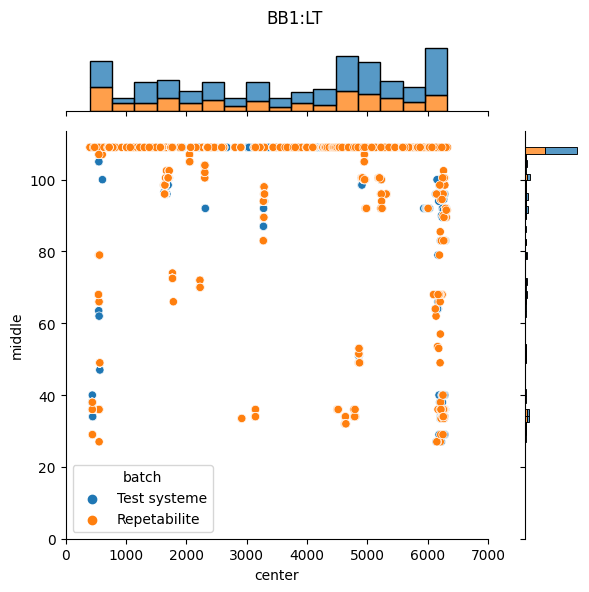

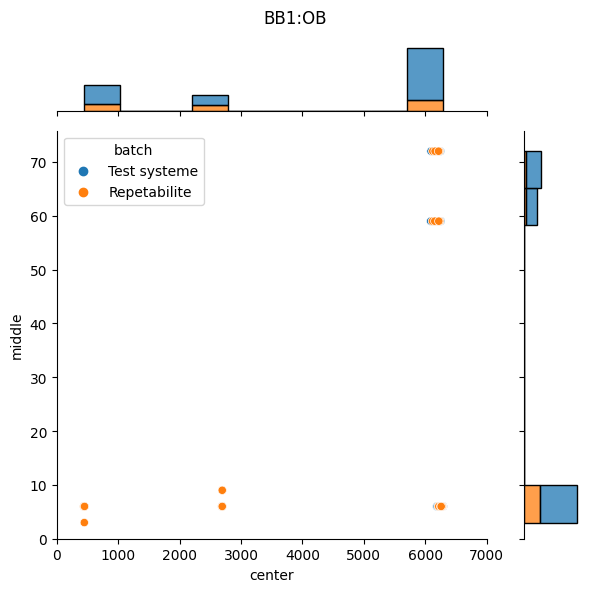

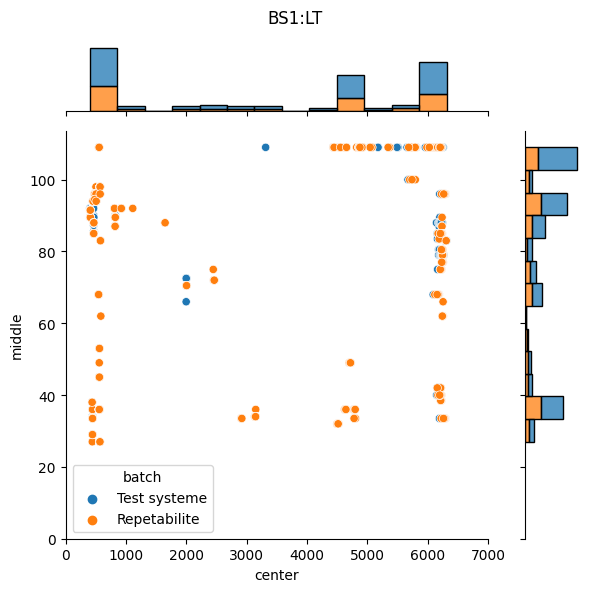

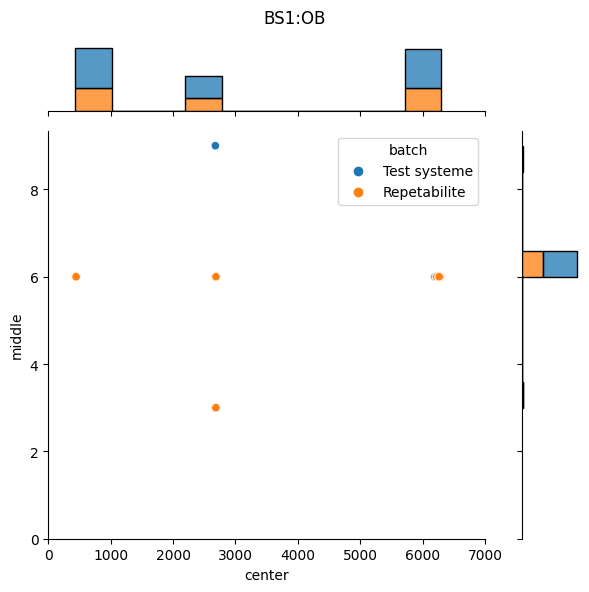

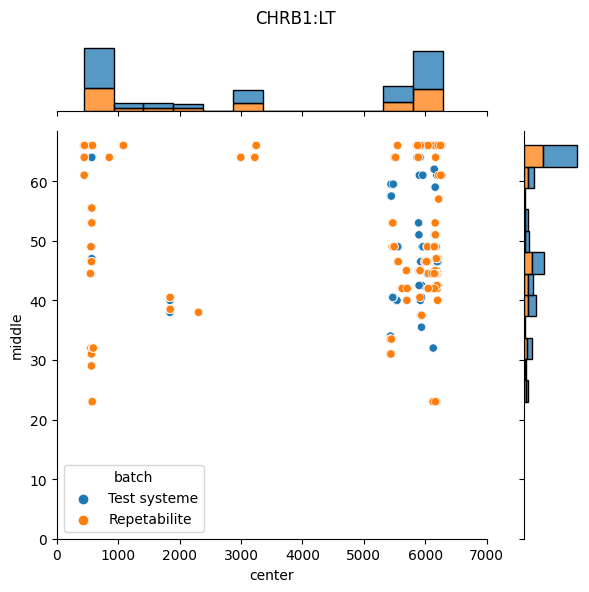

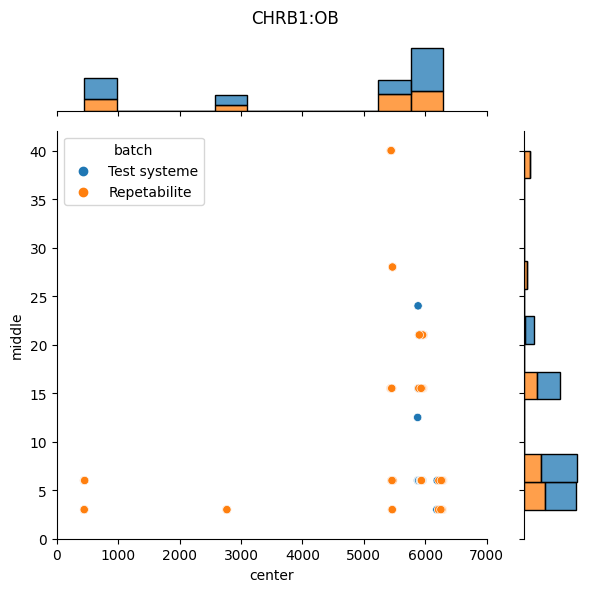

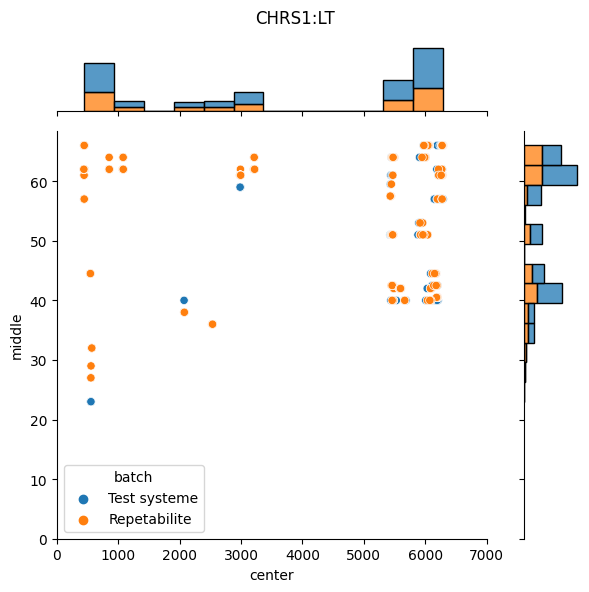

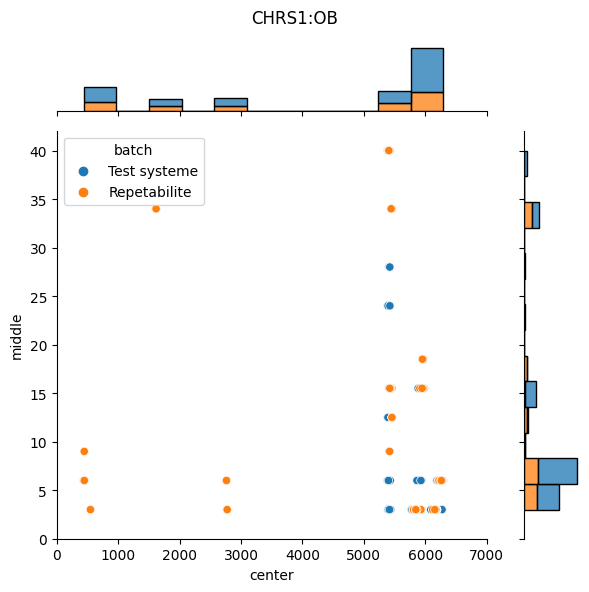

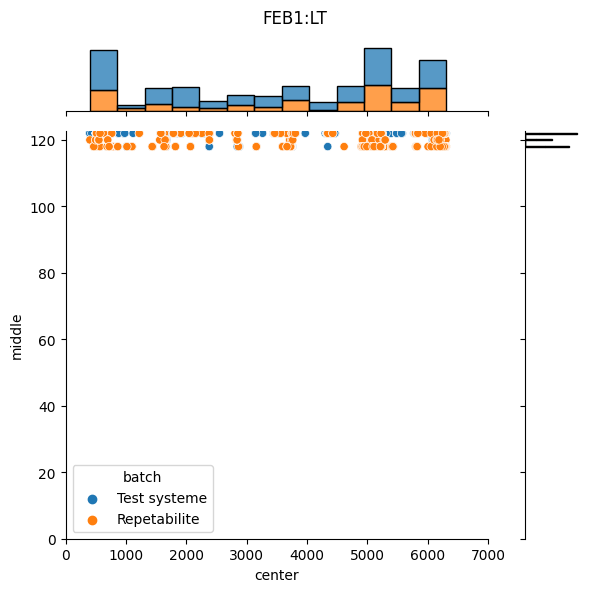

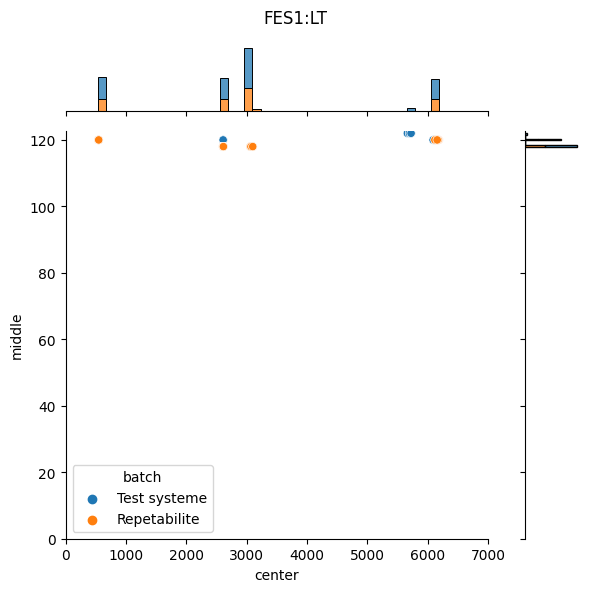

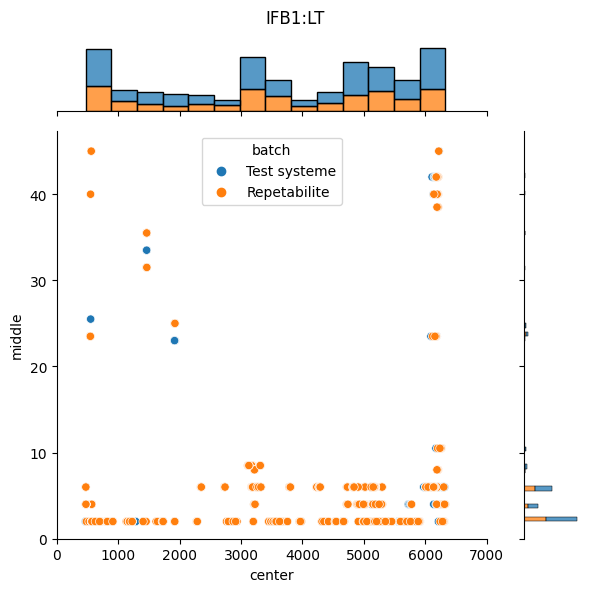

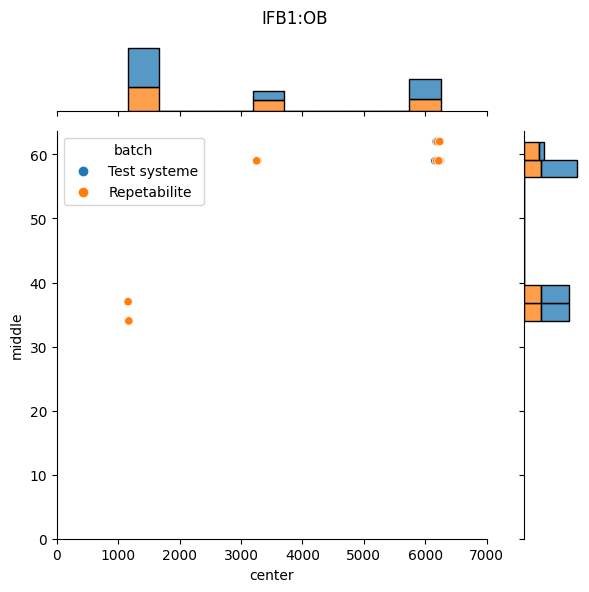

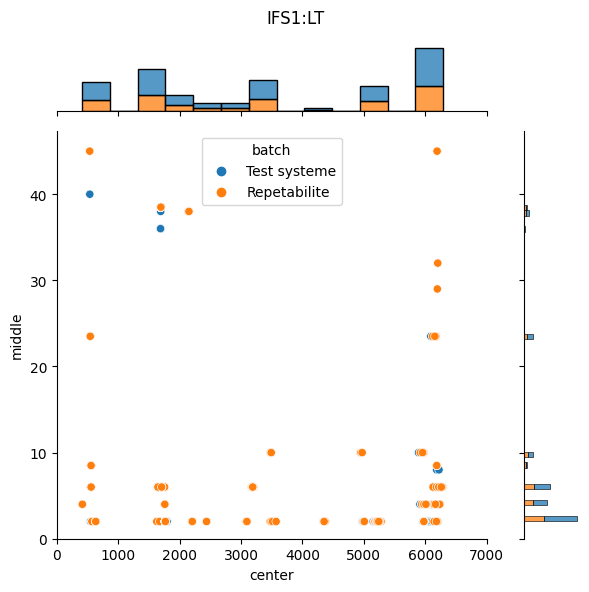

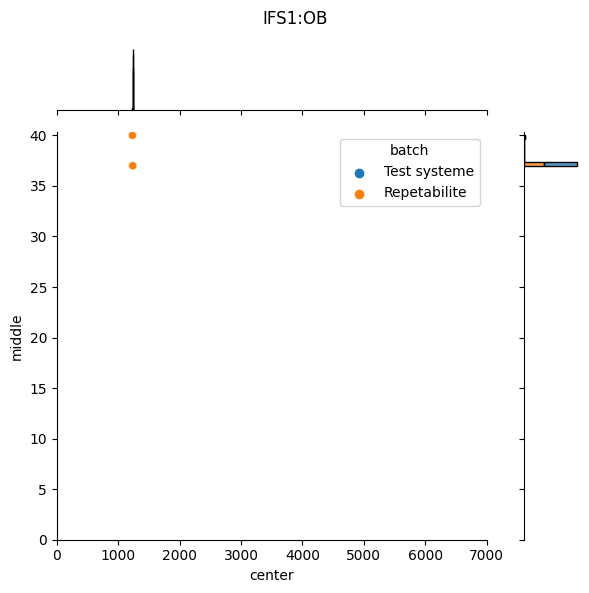

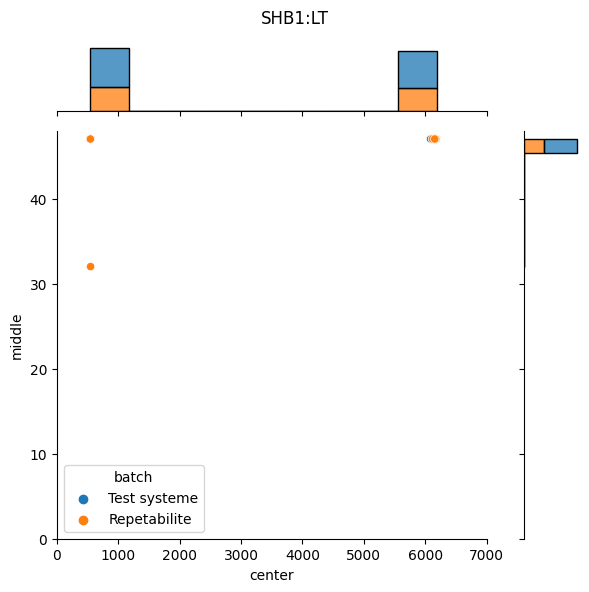

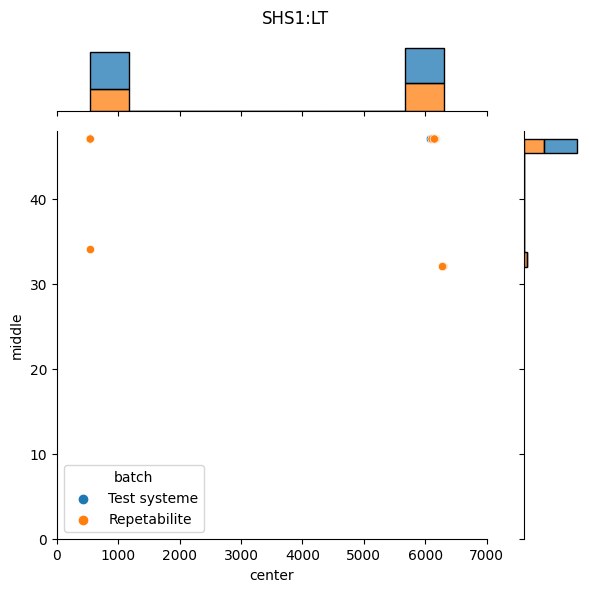

In [15]:
for channel, df in defects_2d_ec.groupby('channel_name'):
    # Set defaults
    df = df.reset_index()
    x='center'
    y='middle'
    hue='batch'
    
    g = sns.JointGrid() # Create the joint plot
    # plot x y data as main data
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        hue=hue, 
        ax=g.ax_joint
    )
    # Add distributions, stacked & split by batch run
    sns.histplot(
        data=df, 
        x=x, 
        hue=hue, 
        multiple='stack', 
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=df,
        y=y,
        hue=hue,
        multiple='stack',
        legend=False,
        ax=g.ax_marg_y,
    )

    #g.plot(sns.scatterplot, sns.histplot)
    g.ax_joint.set_xlim((0,7000))
    ymax = g.ax_joint.get_ylim()[1]
    g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
    g.figure.suptitle(f'{channel}')
    g.figure.tight_layout()

In [16]:
defects_2d_ec.value_counts('channel_name')

channel_name
BB1:LT      6074
IFB1:LT     3727
FEB1:LT     3047
BS1:LT      2758
IFS1:LT     2063
CHRB1:LT    1922
CHRS1:LT    1509
CHRS1:OB     820
CHRB1:OB     637
BB1:OB       500
FES1:LT      372
BS1:OB       370
IFB1:OB      262
SHS1:LT      157
SHB1:LT      147
IFS1:OB       73
dtype: int64

REVIEW Statement of EDA for EC data

Looking at individual channels there are a few where the targets are indicated obviously, and others where there is noise and false positives. Additionally, Looking at both EC and UT data, there are several locations where a target is indicated by both units, but was machined to calibration only one. I need to eliminate the false positives from the dataset. 

I have the known locations based off of a drawing, but need to explore each channel, to determine datum locations and the representation of the "y" value.

As shown in the UT data, there is a range of values in the axial_position for each target. As a complicating factor, the targets for e

Need to import and update the coordinates for 

Going to first focus on the EC, as it has an amplitude. Going to look for gross defects (like edge conditions) then possibly use machine learning for clustering, counting values in the cluster. Small values can be rejected as not defect, and be validate from the print.

# Separate Known EC Targets
Remove false positives. Goal is to determine if the system is seeing all of the desired targets.
Using target locations previously determined earlier

In [19]:
import numpy as np

defects_2d_ec_classified = defects_2d_ec.copy()
defects_2d_ec_classified['target_id'] = np.nan

for channel in defects_2d_ec_classified['channel_name'].unique():
    try:
        targets = target_locations.loc[
            channel, 
            ['axial_location', 'pre', 'post']
        ]
    except KeyError:
        print(f'Channel {channel} not found in target list')
        continue
    for idx, target in targets.iterrows():
        defects_2d_ec_classified.loc[ 
            (defects_2d_ec_classified['channel_name'] == channel) &
            (defects_2d_ec_classified['center'] > target['pre']) &
            (defects_2d_ec_classified['center'] < target['post'])
            ,
            'target_id'
        ] = target['axial_location']

defects_2d_ec_classified.dropna(subset='target_id')

Channel SHS1:LT not found in target list
Channel SHB1:LT not found in target list


amplitude  \
order                   batch        db_index sequence              
RAIL 136 PROVE UP FINAL Test systeme 2366     5             -2.52   
                                              6              3.97   
                                              7             -2.49   
                                              8              2.64   
                                              9             -3.53   
...                                                           ...   
                        Repetabilite 2373     321            3.05   
                                              322            3.78   
                                              323           -2.30   
                                              324           -2.05   
                                              329           -4.82   

                                                       channel_name   top  \
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     5            CHRS1:LT  64.0   
                                              6            CHRS1:LT  64.0   
                                              7            CHRS1:LT  42.0   
                                              8            CHRS1:LT  38.0   
                                              9            CHRS1:LT  67.0   
...                                                             ...   ...   
                        Repetabilite 2373     321            BB1:LT  33.0   
                                              322            BB1:LT  42.0   
                                              323            BB1:LT  38.0   
                                              324            BB1:LT  85.0   
                                              329            BB1:OB  12.0   

                                                          left  bottom  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     5          851.0    60.0   
                                              6         1072.0    60.0   
                                              7         2073.0    34.0   
                                              8         2528.0    34.0   
                                              9         2983.0    55.0   
...                                                        ...     ...   
                        Repetabilite 2373     321       6250.0    25.0   
                                              322       6250.0    38.0   
                                              323       6258.0    30.0   
                                              324       6265.0    81.0   
                                              329       2686.0     0.0   

                                                         right  middle  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     5          855.0    62.0   
                                              6         1086.0    62.0   
                                              7         2078.0    38.0   
                                              8         2537.0    36.0   
                                              9         2988.0    61.0   
...                                                        ...     ...   
                        Repetabilite 2373     321       6256.0    29.0   
                                              322       6256.0    40.0   
                                              323       6259.0    34.0   
                                              324       6266.0    83.0   
                                              329       2701.0     6.0   

                                                        center  yerr  xerr  \
order                   batch        db_index sequence                       
RAIL 136 PROVE UP FINAL Test systeme 2366     5          853.0   2.0   2.0

Channel SHB1:LT not found in target list
Channel SHS1:LT not found in target list


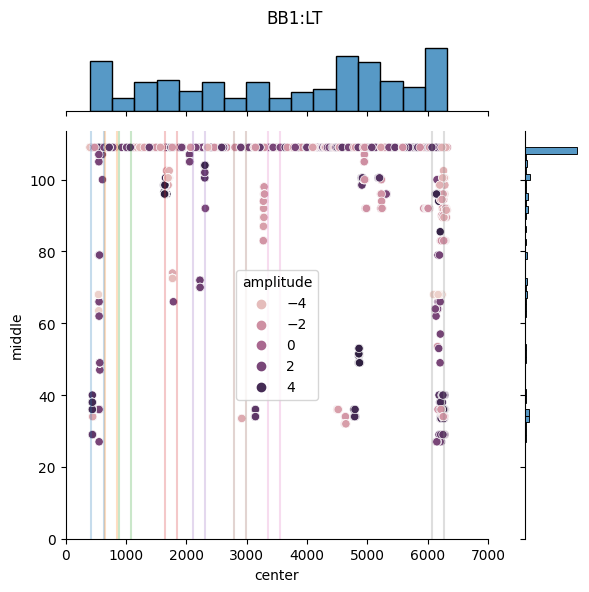

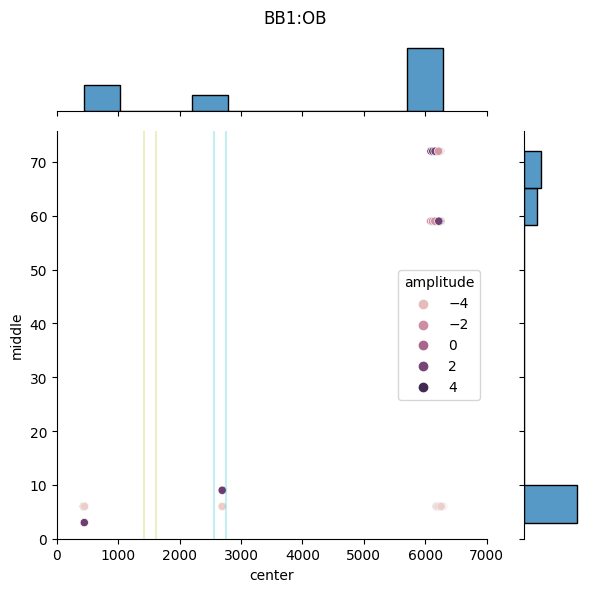

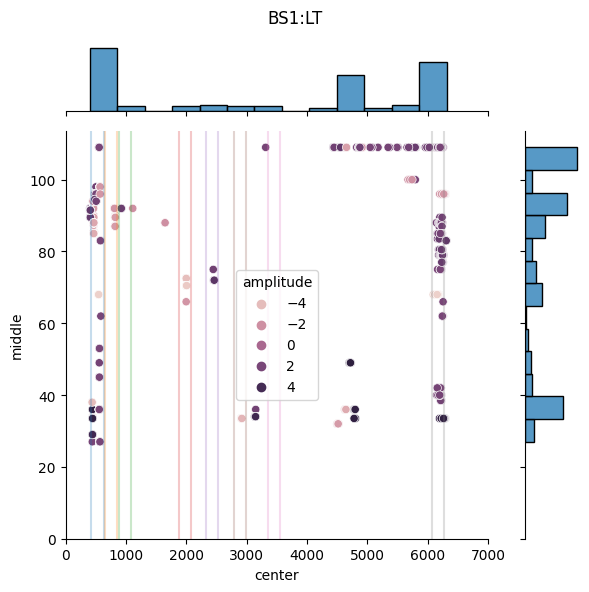

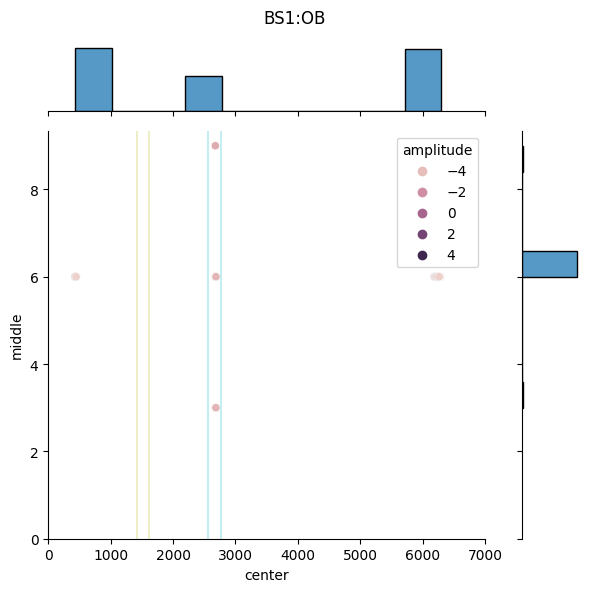

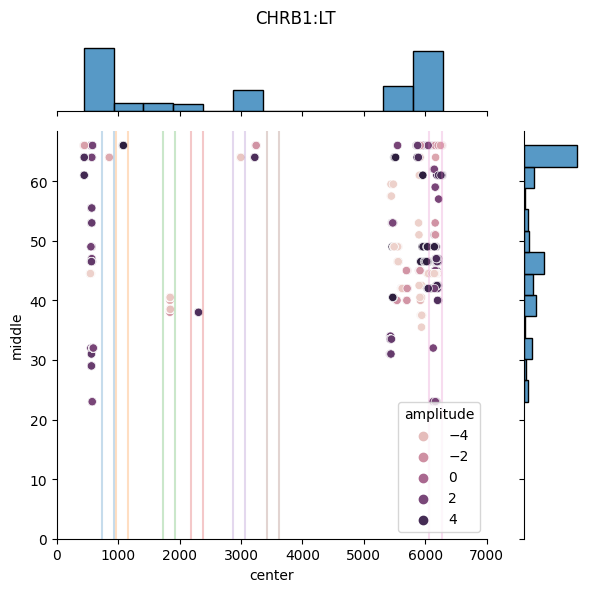

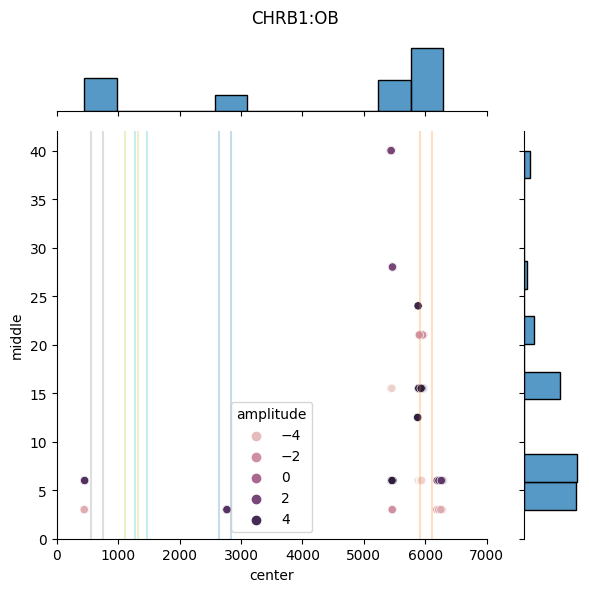

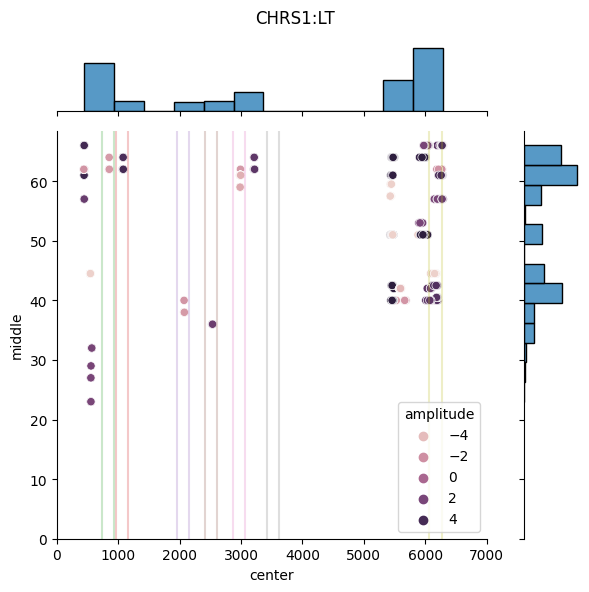

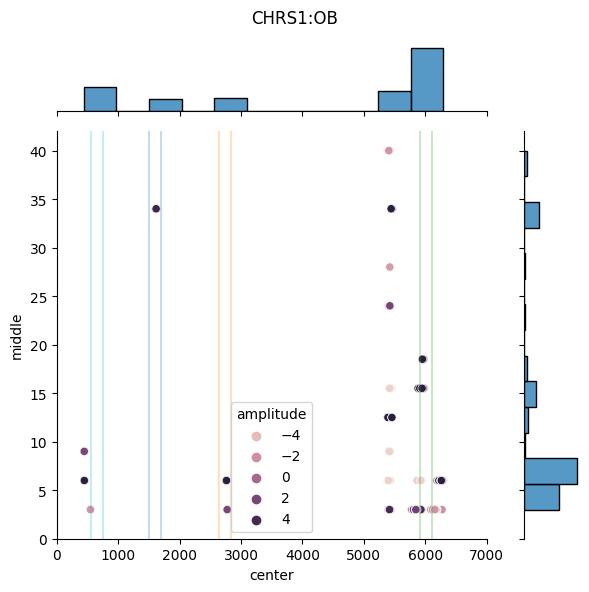

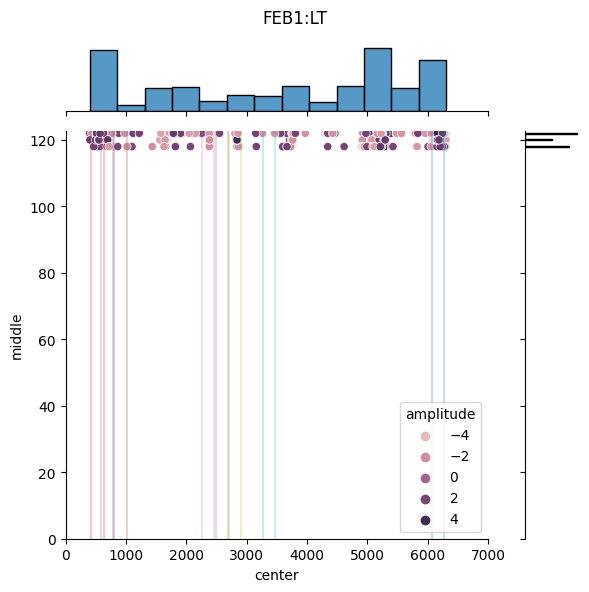

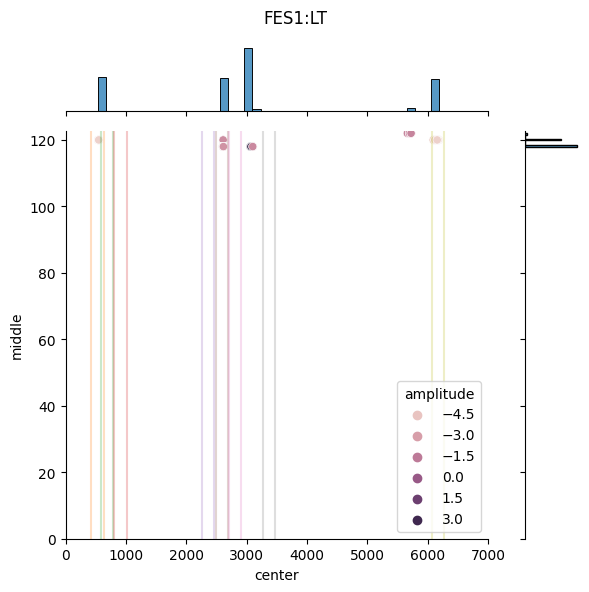

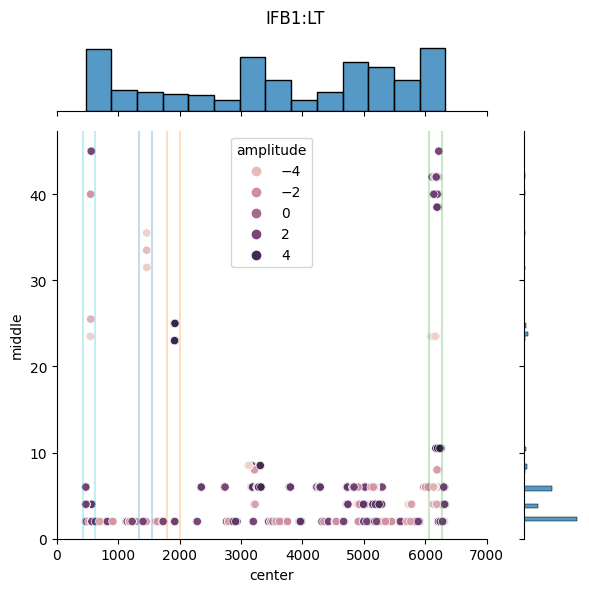

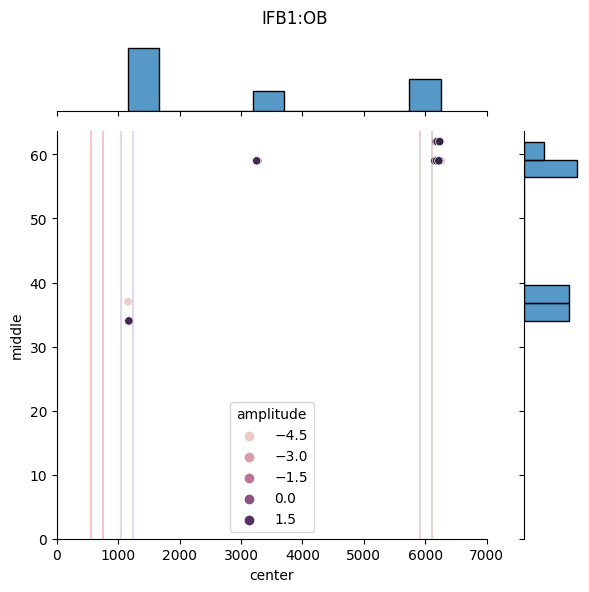

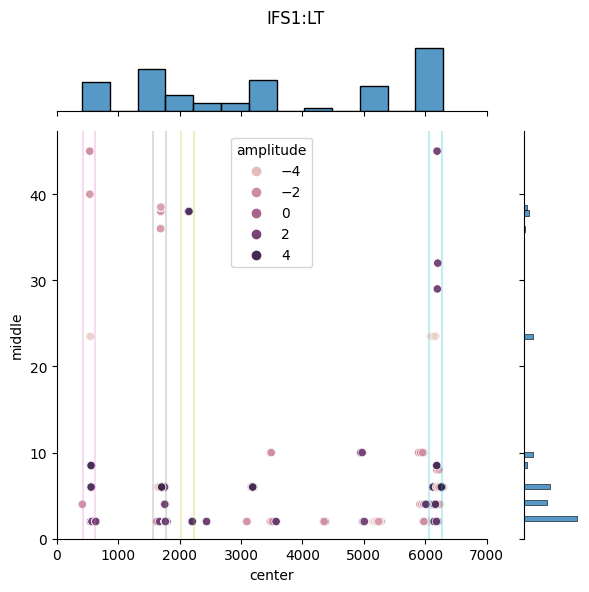

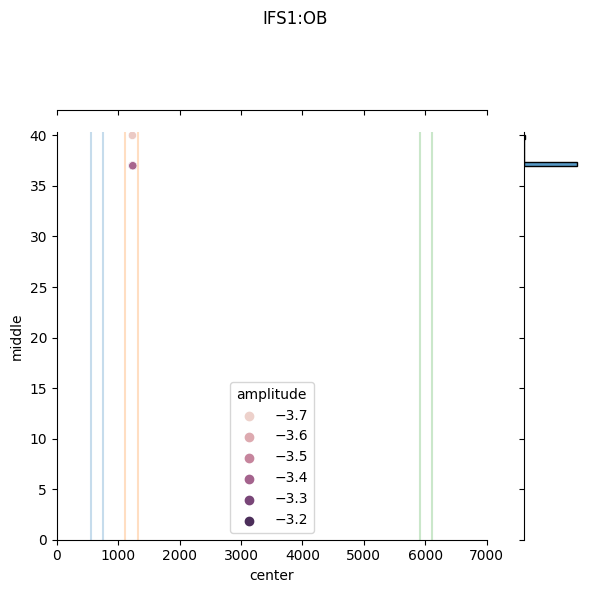

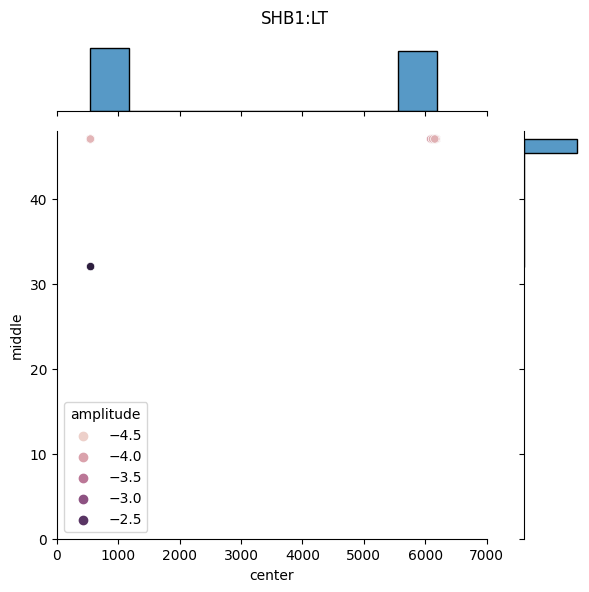

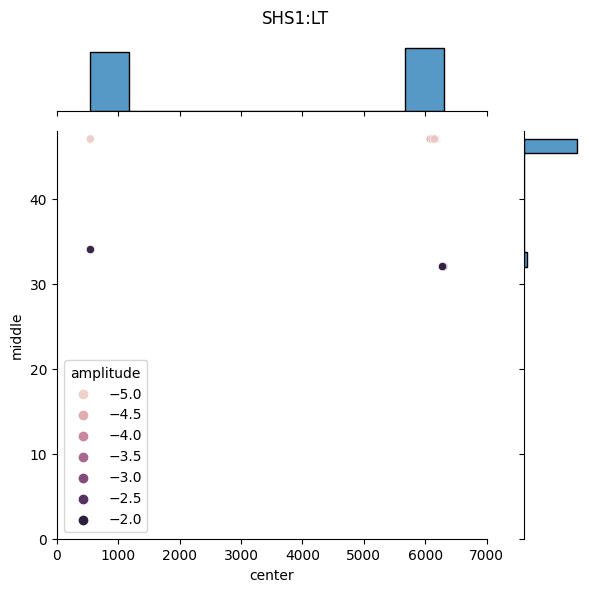

In [20]:
# color cycler from https://stackoverflow.com/questions/28430385/seaborn-cycle-through-colours-with-matplotlib-scatter
from itertools import cycle
palette = cycle(sns.color_palette())

for channel, df in defects_2d_ec.groupby('channel_name'):
    # Set defaults
    df = df.reset_index()
    x='center'
    y='middle'
    hue='batch'
    
    g = sns.JointGrid() # Create the joint plot
    # plot x y data as main data
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        hue='amplitude', 
        ax=g.ax_joint
    )
    try:
        targets = target_locations.loc[channel, ['pre', 'post']]
        for idx, target in targets.iterrows():
            color=next(palette)
            g.ax_joint.axvline(target['pre'], alpha=.35, color=color)
            g.ax_joint.axvline(target['post'], alpha=.35, color=color)
    except KeyError:
        print(f'Channel {channel} not found in target list')

    sns.histplot(
        data=df, 
        x=x, 
        #hue=hue, 
        multiple='stack', 
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=df,
        y=y,
        #hue=hue,
        multiple='stack',
        legend=False,
        ax=g.ax_marg_y,
    )

    #g.plot(sns.scatterplot, sns.histplot)
    g.ax_joint.set_xlim((0,7000))
    ymax = g.ax_joint.get_ylim()[1]
    g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
    g.figure.suptitle(f'{channel}')
    g.figure.tight_layout()

group by channel and , count indications need at least one, flag if zero

In [34]:
defects_2d_ec_counts = (
    defects_2d_ec_classified
    .dropna()
    .reset_index(level='db_index')
    .rename(columns={'channel_name': 'channel'})
    .groupby(
        ['db_index', 'channel', 'target_id']
    )
    ['amplitude']
    .count()
    .rename('count')
)
defects_2d_ec_counts

db_index  channel  target_id
248       BB1:LT   21.0         2
                   150.0        2
                   177.0        1
                   195.0        4
                   225.0        3
                               ..
3392      IFS1:LT  21.0         3
                   180.0        2
                   198.0        8
                   243.0        2
          IFS1:OB  216.0        1
Name: count, Length: 3750, dtype: int64

In [43]:
ec_targets = (
    target_locations
    .loc[
        target_locations['inspection_equipment'] == 'EC'
        , 'axial_location'
    ]
    .rename('target_id')
    .droplevel(-1)
    .reset_index()
)
ec_targets['count'] = 0
ec_targets = ec_targets.set_index(['channel', 'target_id'])

In [51]:
db_indexes = defects_2d_ec_counts.index.get_level_values('db_index').unique()

rails = []
for rail in db_indexes:
    df = ec_targets.copy()
    df.update(defects_2d_ec_counts.loc[rail])
    rails.append(df)

ec_counts = pd.concat(rails, keys=db_indexes)
ec_counts.head(20)

count
db_index channel target_id       
248      :OB     226.5        0.0
                 213.0        0.0
         BB1:LT  243.0       10.0
                 234.0        2.0
                 225.0        3.0
                 195.0        4.0
                 177.0        1.0
                 150.0        2.0
                 128.0        0.0
                 21.0         2.0
         BB1:OB  204.0        0.0
                 159.0        1.0
         BS1:LT  243.0        8.0
                 234.0        2.0
                 225.0        1.0
                 186.0        1.0
                 168.0        1.0
                 150.0        1.0
                 128.0        0.0
                 21.0         8.0

In [108]:
ec_misses = ec_counts[(ec_counts == 0)].dropna().reset_index()
ec_misses = ec_misses[ec_misses['channel'] != ':OB']
ec_misses

,db_index,channel,target_id,count
2,248,BB1:LT,128.0,0.0
3,248,BB1:OB,204.0,0.0
4,248,BS1:LT,128.0,0.0
5,248,BS1:OB,204.0,0.0
6,248,CHRB1,243.0,0.0
...,...,...,...,...
1789,3392,FES1:LT,131.0,0.0
1790,3392,IFB1:OB,238.0,0.0
1791,3392,IFB1:OB,27.0,0.0
1792,3392,IFS1:OB,238.0,0.0


In [109]:
ec_miss_counts = ec_misses.groupby(['channel', 'target_id'])['count'].count()
ec_miss_counts

channel   target_id
BB1:LT    128.0        38
          225.0        17
          234.0         4
BB1:OB    204.0        72
BS1:LT    128.0        72
BS1:OB    204.0        72
CHRB1     243.0        72
CHRB1:LT  125.0        72
CHRB1:OB  27.0         12
          210.0        72
          216.0        72
          238.0        72
CHRS1     243.0        72
CHRS1:LT  125.0        72
CHRS1:OB  27.0          4
          238.0        72
FEB1:LT   131.0        15
          162.0        71
          171.0         1
          228.0        48
FES1:LT   131.0        72
          153.0        72
          171.0        72
          228.0        72
          237.0        72
IFB1:OB   27.0         72
          238.0        72
IFS1:OB   27.0         72
          238.0        72
Name: count, dtype: int64

There are many targets which were not identified on any of the test runs. I'll print them out but will exclude them from future review. The company is likely trying to improve sensitivity. One target was missed by all test runs but one. This likely is a false positive, so a 95% confidence was added to the exclusion

In [110]:
ec_always_miss = (
    ec_miss_counts
    [ec_miss_counts > 0.95 * len(db_indexes)]
    .index
    .unique()
    #.to_frame()
)
ec_always_miss


MultiIndex([(  'BB1:OB', 204.0),
            (  'BS1:LT', 128.0),
            (  'BS1:OB', 204.0),
            (   'CHRB1', 243.0),
            ('CHRB1:LT', 125.0),
            ('CHRB1:OB', 210.0),
            ('CHRB1:OB', 216.0),
            ('CHRB1:OB', 238.0),
            (   'CHRS1', 243.0),
            ('CHRS1:LT', 125.0),
            ('CHRS1:OB', 238.0),
            ( 'FEB1:LT', 162.0),
            ( 'FES1:LT', 131.0),
            ( 'FES1:LT', 153.0),
            ( 'FES1:LT', 171.0),
            ( 'FES1:LT', 228.0),
            ( 'FES1:LT', 237.0),
            ( 'IFB1:OB',  27.0),
            ( 'IFB1:OB', 238.0),
            ( 'IFS1:OB',  27.0),
            ( 'IFS1:OB', 238.0)],
           names=['channel', 'target_id'])

In [111]:
ec_miss_counts = ec_miss_counts[ec_miss_counts < 0.95 * len(db_indexes)]
miss_rate = ec_miss_counts/len(db_indexes)
miss_rate

channel   target_id
BB1:LT    128.0        0.527778
          225.0        0.236111
          234.0        0.055556
CHRB1:OB  27.0         0.166667
CHRS1:OB  27.0         0.055556
FEB1:LT   131.0        0.208333
          171.0        0.013889
          228.0        0.666667
Name: count, dtype: float64

Which runs missed?

In [132]:
(
    ec_counts
    .reset_index('db_index')
    .loc[
        ~ec_counts.reset_index('db_index').index.isin(ec_always_miss) &
        (ec_counts['count'] == 0).to_numpy() &
        (ec_counts.index.get_level_values('channel') != ':OB'),
        'db_index'
    ]
    .reset_index()
    .set_index('db_index')
)

,channel,target_id
db_index,,
248,BB1:LT,128.0
248,FEB1:LT,228.0
249,BB1:LT,225.0
249,BB1:LT,128.0
249,FEB1:LT,228.0
...,...,...
3388,FEB1:LT,228.0
3388,FEB1:LT,131.0
3389,BB1:LT,225.0


upload to test database for certification purposes.

Validation formalization

Zeroing and flipping data

In [ ]:
defects_2d_ec_shifted = defects_2d_ec.copy()
# Determine the furthest left axially
axial_min = (
    defects_2d_ec_shifted
    .groupby(level='db_index')
    .transform('min') # Use original index
    ['left']
)

defects_2d_ec_shifted.loc[:,['left', 'right', 'center']] = (
    defects_2d_ec_shifted.loc[:,['left', 'right', 'center']] - 
    pd.concat([ # Rename to match indexes, subtracting from each
        axial_min, 
        axial_min.rename('right'), 
        axial_min.rename('center')
    ], axis=1)
)
defects_2d_ec_shifted

amplitude  \
order                   batch        db_index sequence              
RAIL 136 PROVE UP FINAL Test systeme 2366     0             -2.36   
                                              1              4.14   
                                              2              2.78   
                                              3             -2.01   
                                              4             -5.00   
...                                                           ...   
                        Repetabilite 2373     331            2.29   
                                              332           -2.43   
                                              333            2.30   
                                              334            4.57   
                                              335           -4.83   

                                                       channel_name   top  \
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     0            CHRS1:LT  64.0   
                                              1            CHRS1:LT  68.0   
                                              2            CHRS1:LT  59.0   
                                              3            CHRS1:LT  64.0   
                                              4            CHRS1:LT  68.0   
...                                                             ...   ...   
                        Repetabilite 2373     331            BB1:OB  75.0   
                                              332            BB1:OB  75.0   
                                              333            BB1:OB  62.0   
                                              334            BB1:OB  12.0   
                                              335            BB1:OB  12.0   

                                                          left  bottom  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0           36.0    60.0   
                                              1           40.0    64.0   
                                              2           41.0    55.0   
                                              3           48.0    60.0   
                                              4          138.0    21.0   
...                                                        ...     ...   
                        Repetabilite 2373     331       5754.0    69.0   
                                              332       5808.0    69.0   
                                              333       5813.0    56.0   
                                              334       5848.0     0.0   
                                              335       5855.0     0.0   

                                                         right  middle  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0           39.0    62.0   
                                              1           45.0    66.0   
                                              2           45.0    57.0   
                                              3           49.0    62.0   
                                              4          149.0    44.5   
...                                                        ...     ...   
                        Repetabilite 2373     331       5763.0    72.0   
                                              332       5822.0    72.0   
                                              333       5825.0    59.0   
                                              334       5854.0     6.0   
                                              335       5861.0     6.0   

                                                        center  yerr  xerr  
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     0           37.5   2.0   1.5  

IFS1:LT & IFB1:LT

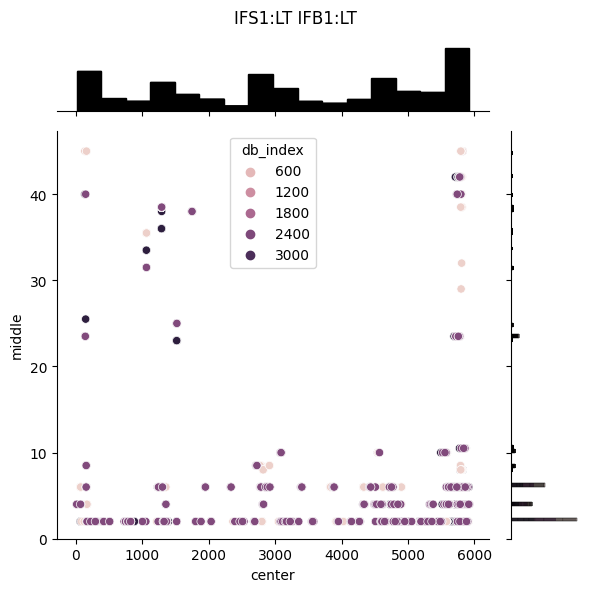

In [ ]:
df = defects_2d_ec_shifted[
    defects_2d_ec_shifted['channel_name'].isin(['IFS1:LT', 'IFB1:LT']) #&
    #(defects_2d_ec_shifted['center'] > 6000)
    ].reset_index()

x='center'
y='middle'
#hue='channel_name'
hue = 'db_index'

g = sns.JointGrid() # Create the joint plot
# plot x y data as main data
sns.scatterplot(
    data=df, 
    x=x, 
    y=y, 
    hue=hue, 
    ax=g.ax_joint
)
# Add distributions, stacked & split by batch run
sns.histplot(
    data=df, 
    x=x, 
    hue=hue, 
    multiple='stack', 
    legend=False,
    ax=g.ax_marg_x,
)
sns.histplot(
    data=df,
    y=y,
    hue=hue,
    multiple='stack',
    legend=False,
    ax=g.ax_marg_y,
)

#g.plot(sns.scatterplot, sns.histplot)
#g.ax_joint.set_xlim((0,7000))
ymax = g.ax_joint.get_ylim()[1]
g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
g.figure.suptitle('IFS1:LT IFB1:LT')
g.figure.tight_layout()

Tried shifting, not working as expected. Hoping to align slight variations in horizontal space, assuming that the first indication was the edge of the rail. To match with the print, the zero value is close to the end of the rail. Shifting does not provide the desired outcome

Pick a channel
Narrow down by axial position +/-50mm
 BB1 LT 



Looking at the data for BS1:LT and BB1:LT, there is a solid line of indications at 109 mm. These are likely the edge effects

In [ ]:
# Identification of edge effects on BS1:LT and BB1:LT

pd.concat([
    defects_2d_ec.loc[
        defects_2d_ec['channel_name'] == 'BS1:LT',
        'middle'
    ].rename('BS1:LT').value_counts(),
    defects_2d_ec.loc[
        defects_2d_ec['channel_name'] == 'BB1:LT',
        'middle'
    ].rename('BB1:LT').value_counts(),

], axis=1).head()


,BS1:LT,BB1:LT
109.0,667.0,3764.0
33.5,222.0,99.0
96.0,194.0,167.0
36.0,168.0,249.0
92.0,155.0,142.0


In [ ]:
# Removal of edge effects on BS1:LT and BB1:LT
defects_2d_ec = defects_2d_ec.loc[
    ~(
        defects_2d_ec['channel_name'].isin(['BS1:LT', 'BB1:LT']) & 
        (defects_2d_ec['middle'] == 109.0)
    )
]